In [1]:
#data
import pandas as pd
import numpy as np
import re
from collections import Counter
import string
import os

#geo
import geopandas as gpd
import contextily as cx
from shapely.geometry import MultiPolygon, Polygon
from shapely.ops import unary_union

#plotting
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from adjustText import adjust_text
from matplotlib.lines import Line2D

In [ ]:
# Save everything installed in the environment
#pip freeze > requirements.txt
#conda list --export > requirements.txt
#conda env export > environment.yml

In [3]:
#seaborn settings
sns.set_style("whitegrid", {"font.family":"serif"}) #match font to report
#sns.set_palette(palette=["#9e86FA", "#009E73"]) #checked in colour-blind simulator
sns.set_palette(palette="tab20") #default for categorical data

In [4]:
#helper functions
def save_csv(df, output_path, index=False, encoding="utf-8"):
    """Save csv and create folder if it doesn't yet exist."""
    output_dir = os.path.dirname(output_path)
    os.makedirs(output_dir, exist_ok=True)
    df.to_csv(output_path, index=index, encoding=encoding)

def sub_value(dfcol, pattern, replacement):
    """
    Replace matching string patterns in a Pandas Series using a regex.
    
    dfcol (pd.Series): dataframe["column_name"] -- The column (Series) in which to search and replace.
    pattern (str): r"to replace" -- Regex pattern to search for.
    replacement (str): "to insert" -- String to replace the matched pattern with.

    Returns: pd.Series -- The modified Series with replacements applied.
    """
    dfcol = dfcol.astype(str)
    dfcol = dfcol.str.replace(pattern, replacement, regex=True)
    return dfcol

def count_dialects(dialect_str):
    if pd.isna(dialect_str) or dialect_str.strip() == "keine":
        return 0
    dialects = [d.strip() for d in dialect_str.split(",") if d.strip()]
    return len(set(dialects))

# Preprocessing data

In [5]:
#load raw data
df_raw = pd.read_csv("./Data.csv", encoding="utf-8")
df_raw.head()

,Respondent,Mehrsprachig aufgewachsen,Alter,Geschlecht,Dialecteinfluss,Region,Ausland,der Park,der Biskuit,der Jodel,...,der Cherpak,der Kniempe,der Pommeng,der Sampa,das Fliffel,das Deipfer,das Istrat,das Virong,das Nofte,das Brolck
0,1,NaN,19-30,Weiblich,"Bairisch, Schwäbisch",U,mehr als 10 Jahre,Parks,Biskuits,Jodel,...,Cherpaks,Kniempen,Pommengen,Sampas,Fliffel,Deipfer,Istrate,Virongs,Nofte,Brolcke
1,2,Y,19-30,Weiblich,Keine,NaN,1-5 Jahre,Parks,Biskuits,Jodel,...,Cherpake,Kniempen,Pommenge,Sampas,Fliffel,Deipfer,Istrate,Vironge,Nofte,Brolcks
2,3,Y,19-30,Weiblich,Kärntnerisch,U,Nicht zutreffend/Weniger als 1 Jahr,Parks,Biskuits,Jodel,...,Cherpaks,Kniempen,Pommemge,Sampas,Fliffel,Deipfer,Istrate,Vironge,Noften,Brolcke
3,4,NaN,19-30,Männlich,Thüringisch,C,Nicht zutreffend/Weniger als 1 Jahr,Parks,Biskuits,Jodel,...,Cherpaken,Kniempen,Pommengen,Sampen,Fliffel,Deipfer,Istrate,Virongen,Noften,Brolcken
4,5,NaN,19-30,Männlich,Bairisch,U,Nicht zutreffend/Weniger als 1 Jahr,Parks,Biskuit,Jodel,...,Cherpaki,Kniempen,Pommeng,Sampas,Fliffel,Deipfer,Istrate,Virongs,Nofte,Brolcke


In [6]:
import researchpy as rp
rp.codebook(df_raw)

Variable: Respondent    Data Type: int64 

 Number of Obs.: 219 
 Number of missing obs.: 0 
 Percent missing: 0.0 
 Number of unique values: 219 

 Range: [1, 219] 
 Mean: 110.0 
 Standard Deviation: 63.36 
 Mode: 1 
 10th Percentile: 22.8 
 25th Percentile: 55.5 
 50th Percentile: 110.0 
 75th Percentile: 164.5 
 90th Percentile: 197.20000000000002 





Variable: Mehrsprachig aufgewachsen    Data Type: object 

 Number of Obs.: 219 
 Number of missing obs.: 193 
 Percent missing: 88.13 
 Number of unique values: 1 

 Data Values and Counts: 
 
 Values  Frequency
     Y         26




Variable: Alter    Data Type: object 

 Number of Obs.: 219 
 Number of missing obs.: 0 
 Percent missing: 0.0 
 Number of unique values: 5 

 Data Values and Counts: 
 
 Values  Frequency
 19-30        121
 31-40         44
 41-50         30
 51-60         14
   60+         10




Variable: Geschlecht    Data Type: object 

 Number of Obs.: 219 
 Number of missing obs.: 1 
 Percent missing: 0.46 
 Numb

 Data Values and Counts: 
 
  Values  Frequency
      C         30
   C, U          2
      L         26
   L, C          5
   L, U          5
    L,C          1
      U        123
   U, C          1
U, C, L          3
   U, L          2




Variable: Ausland    Data Type: object 

 Number of Obs.: 219 
 Number of missing obs.: 0 
 Percent missing: 0.0 
 Number of unique values: 72 

 Data Values and Counts: 
 
                                                                      Values  Frequency
 1 Jahr in Argentiniern (vor 10 Jahren), 6 Monate in Spanien (vor 4 Jahren)          1
                                                                  1-5 Jahre         12
             1-5 Jahre, 3 Jahre in Schottland und 1 Jahr in Kanada (Québec)          1
                                                     1-5 Jahre, Argentinien          1
 1-5 Jahre, Belgien (Brüssel) - französisch- und englischsprachiger Kontext          1
                        1-5 Jahre, Costa Rica, Spanien, Schwed

## Personal data

In [7]:
df_proc = df_raw.copy()

#rename personal data columns
df_proc = df_proc.rename(columns={"Respondent":"respondent",
                                 "Mehrsprachig aufgewachsen":"bilingual",
                                 "Alter":"age",
                                 "Geschlecht":"gender",
                                 "Dialecteinfluss":"dialects",
                                 "Ausland":"years_abroad",
                                  })

#remove region col - this was handcoded and could be mistakes/inconsistencies
df_proc = df_proc.drop("Region", axis=1) 

#strip and make everything lower case
df_proc = df_proc.apply(lambda col: col.str.lower().str.strip() if col.dtype == "object" else col) 

#inspect unique values in personal data columns
for col in df_proc.columns[1:6]:
    print(f"\n{col}:")
    print(df_proc[col].dropna().unique())
    
df_proc.head()


bilingual:
['y']

age:
['19-30' '31-40' '41-50' '60+' '51-60']

gender:
['weiblich' 'männlich']

dialects:
['bairisch, schwäbisch' 'keine' 'kärntnerisch' 'thüringisch' 'bairisch'
 'hessisch' 'schwäbisch' 'steirisch' 'allgäuerisch, bairisch, schwäbisch'
 'bairisch, steirisch' 'kärntnerisch, steirisch'
 'steirisch, burgenländisch' 'berlinerisch, sächsisch' 'salzburgerisch'
 'fränkisch, schwäbisch' 'bairisch, berlinerisch, westfälisch'
 'westfälisch' 'sächsisch'
 'bairisch, hianzisch/burgenländisch, steirisch, wienerisch'
 'alemannisch, allgäuerisch, bairisch' 'alemannisch, schwäbisch'
 'wienerisch' 'tirolerisch, vorarlbergerisch, wienerisch'
 'vorarlbergerisch' 'berlinerisch, thüringisch'
 'salzburgerisch, wienerisch, niederösterreichisch'
 'salzburgerisch, wienerisch' 'hamburgerisch' 'berlinerisch, schwäbisch'
 'bairisch, kärntnerisch, salzburgerisch, schwäbisch, steirisch'
 'steirisch, wienerisch' 'tirolerisch, wienerisch' 'steirisch, grazerisch'
 'fränkisch' 'berlinerisch'
 'bairisch

,respondent,bilingual,age,gender,dialects,years_abroad,der Park,der Biskuit,der Jodel,der Schal,...,der Cherpak,der Kniempe,der Pommeng,der Sampa,das Fliffel,das Deipfer,das Istrat,das Virong,das Nofte,das Brolck
0,1,NaN,19-30,weiblich,"bairisch, schwäbisch",mehr als 10 jahre,parks,biskuits,jodel,schals,...,cherpaks,kniempen,pommengen,sampas,fliffel,deipfer,istrate,virongs,nofte,brolcke
1,2,y,19-30,weiblich,keine,1-5 jahre,parks,biskuits,jodel,schals,...,cherpake,kniempen,pommenge,sampas,fliffel,deipfer,istrate,vironge,nofte,brolcks
2,3,y,19-30,weiblich,kärntnerisch,nicht zutreffend/weniger als 1 jahr,parks,biskuits,jodel,schale,...,cherpaks,kniempen,pommemge,sampas,fliffel,deipfer,istrate,vironge,noften,brolcke
3,4,NaN,19-30,männlich,thüringisch,nicht zutreffend/weniger als 1 jahr,parks,biskuits,jodel,schals,...,cherpaken,kniempen,pommengen,sampen,fliffel,deipfer,istrate,virongen,noften,brolcken
4,5,NaN,19-30,männlich,bairisch,nicht zutreffend/weniger als 1 jahr,parks,biskuit,jodel,schals,...,cherpaki,kniempen,pommeng,sampas,fliffel,deipfer,istrate,virongs,nofte,brolcke


In [8]:
#clean data values
#=====Did you grow up bilingual?=====
#make binary y1 / n0
df_proc["bilingual"] = df_proc["bilingual"].fillna("0") #NaNs are those who answered no # make clear this was no and not just blank
df_proc["bilingual"] = sub_value(df_proc["bilingual"], r"y", "1")

#=====How old are you?=====
#all ok

#=====Which gender do you identify with? [only non compulsory question]=====
# make binary 0f / 1m
df_proc["gender"] = sub_value(df_proc["gender"],r"männlich","1")
df_proc["gender"] = sub_value(df_proc["gender"],r"weiblich","0")
                                                   
#=====Which dialects would you say have had the greatest influence on your German?=====
df_proc["dialects"] = df_proc["dialects"].fillna("keine") #NaNs are those who answered "none"
df_proc["dialects"] = sub_value(df_proc["dialects"], r"[^\w\s,]", "") #remove punctuation except commas (match anything but word/whitespace/comma)

#normalise variant spellings and remove any irrelevant comments left in the 'other' field
df_proc["dialects"] = sub_value(df_proc["dialects"],r"versch schweizer dialekte","schweizerisch") # Various Swiss dialects -> Swiss 
df_proc["dialects"] = sub_value(df_proc["dialects"],r"schweizerdeutsch\b,?","schweizerisch") #normalise to swiss
df_proc["dialects"] = sub_value(df_proc["dialects"],r"schweizer\b,?","schweizerisch") #normalise to swiss
df_proc["dialects"] = sub_value(df_proc["dialects"],r"berliner\b,?","berlinerisch") # normalise to "Berlinese"
df_proc["dialects"] = sub_value(df_proc["dialects"],r"teuteburger","teutoburgerisch") #add adjective ending to match other names
df_proc["dialects"] = sub_value(df_proc["dialects"],r"lippe liegt im teutoburgerisch wald","") #remove info about where the dialekt is spoken 'lippe is located in the Teutoburg Forest'
df_proc["dialects"] = sub_value(df_proc["dialects"],r"hianzischburgenländisch","hianzisch, burgenländisch") #add comma inbetween words
df_proc["dialects"] = sub_value(df_proc["dialects"],r"schlesische herkunft meiner mutter","schlesisch") #'my mum is swabian' -> Swabian
df_proc["dialects"] = sub_value(df_proc["dialects"],r"banater schwäbisch","banatschwäbisch") #make one-word adjective 
df_proc["dialects"] = sub_value(df_proc["dialects"],r"unterscheidet sich von tirolerisch","") #remove comment saying south tyrolean is different from plain tirolean ('differs from tyrolean')
df_proc["dialects"] = sub_value(df_proc["dialects"],r"dialekt","") #remove any mentions of dialect as just need adjectives

#=====Have you ever lived anywhere outside the German-speaking area? If so, how long/where? (years,place) =====
#make times numeric and place separate:
#extract place from time_abroad to new column
abroad_jahr = df_proc["years_abroad"].str.extract(r"jahr(?:e)?,\s*(.*)", expand=False).str.strip() #everything after jahr(e) ('year(s)')
abroad_seit = df_proc["years_abroad"].str.extract(r"seit\s*(.*)", expand=False).str.strip() #everything after seit ('since')
combined_place = abroad_jahr.combine_first(abroad_seit) #create list of places
col_idx = df_proc.columns.get_loc("years_abroad")
df_proc.insert(loc=col_idx + 1, column="time_abroad_place", value=combined_place) #insert next to time column

#clean time column
#remove place
def remove_place(row):
    time_abroad = str(row["years_abroad"])
    place = str(row["time_abroad_place"])
    if place:
        time_abroad = time_abroad.replace(place, "").strip() #remove extracted places from time col
        time_abroad = re.sub(r",\s*$", "", time_abroad).strip() #clean leftover commas
    return time_abroad
df_proc["years_abroad"] = df_proc.apply(remove_place, axis=1)

#make times just numerical
df_proc["years_abroad"] = sub_value(df_proc["years_abroad"],r"mehr als 10 jahre","10+")
df_proc["years_abroad"] = sub_value(df_proc["years_abroad"],r"1-5 jahre","1-5")
df_proc["years_abroad"] = sub_value(df_proc["years_abroad"],r"nicht zutreffend/weniger als 1 jahr","<1")

#manually clean/add more complex locations/times not captured by regex
custom_patterns = [
    r"1 jahr in argentiniern \(vor 10 jahren\), 6 monate in spanien \(vor 4 jahren\)",
    r"5 j finnland, 1 j jordanien, 2 j usa, 20 j großbritannien",
    r"spanien - 1 jahr; großbritannien - 3 jahre",
    r"2 jahre russland, 2 jahre schottland, 15 jahre england",
    r"seit",
    r"jahre"
]
for pattern in custom_patterns:    
    matched = df_proc["years_abroad"].str.extract(f"({pattern})", expand=False).str.strip()
    df_proc["time_abroad_place"] = df_proc["time_abroad_place"].combine_first(matched)
    df_proc["years_abroad"] = df_proc["years_abroad"].str.replace(pattern, "", regex=True).str.strip()

#manually add time abroad back in
df_proc.loc[14, "years_abroad"] = "1–5"
df_proc.loc[58, "years_abroad"] = "1–5"
df_proc.loc[84, "years_abroad"] = "10+"
df_proc.loc[109, "years_abroad"] = "10+"
df_proc.loc[151, "years_abroad"] = "10+"
df_proc.loc[199, "years_abroad"] = "10+"

df_proc.head()

,respondent,bilingual,age,gender,dialects,years_abroad,time_abroad_place,der Park,der Biskuit,der Jodel,...,der Cherpak,der Kniempe,der Pommeng,der Sampa,das Fliffel,das Deipfer,das Istrat,das Virong,das Nofte,das Brolck
0,1,0,19-30,0,"bairisch, schwäbisch",10+,NaN,parks,biskuits,jodel,...,cherpaks,kniempen,pommengen,sampas,fliffel,deipfer,istrate,virongs,nofte,brolcke
1,2,1,19-30,0,keine,1-5,NaN,parks,biskuits,jodel,...,cherpake,kniempen,pommenge,sampas,fliffel,deipfer,istrate,vironge,nofte,brolcks
2,3,1,19-30,0,kärntnerisch,<1,NaN,parks,biskuits,jodel,...,cherpaks,kniempen,pommemge,sampas,fliffel,deipfer,istrate,vironge,noften,brolcke
3,4,0,19-30,1,thüringisch,<1,NaN,parks,biskuits,jodel,...,cherpaken,kniempen,pommengen,sampen,fliffel,deipfer,istrate,virongen,noften,brolcken
4,5,0,19-30,1,bairisch,<1,NaN,parks,biskuit,jodel,...,cherpaki,kniempen,pommeng,sampas,fliffel,deipfer,istrate,virongs,nofte,brolcke


In [9]:
#check unique values in personal data columns
for col in df_proc.columns[1:6]:
    print(f"\n{col}:")
    print(df_proc[col].dropna().unique())
print(df_proc["time_abroad_place"].dropna().unique())


bilingual:
['0' '1']

age:
['19-30' '31-40' '41-50' '60+' '51-60']

gender:
['0' '1' 'nan']

dialects:
['bairisch, schwäbisch' 'keine' 'kärntnerisch' 'thüringisch' 'bairisch'
 'hessisch' 'schwäbisch' 'steirisch' 'allgäuerisch, bairisch, schwäbisch'
 'bairisch, steirisch' 'kärntnerisch, steirisch'
 'steirisch, burgenländisch' 'berlinerisch, sächsisch' 'salzburgerisch'
 'fränkisch, schwäbisch' 'bairisch, berlinerisch, westfälisch'
 'westfälisch' 'sächsisch'
 'bairisch, hianzisch, burgenländisch, steirisch, wienerisch'
 'alemannisch, allgäuerisch, bairisch' 'alemannisch, schwäbisch'
 'wienerisch' 'tirolerisch, vorarlbergerisch, wienerisch'
 'vorarlbergerisch' 'berlinerisch, thüringisch'
 'salzburgerisch, wienerisch, niederösterreichisch'
 'salzburgerisch, wienerisch' 'hamburgerisch' 'berlinerisch, schwäbisch'
 'bairisch, kärntnerisch, salzburgerisch, schwäbisch, steirisch'
 'steirisch, wienerisch' 'tirolerisch, wienerisch' 'steirisch, grazerisch'
 'fränkisch' 'berlinerisch'
 'bairisch, h

## Token cleaning

In [10]:
#=====clean tokens=====
tokens_cols = [col for col in df_proc.columns if col.startswith(("der", "die", "das"))] #anything starting with an article is a noun

#words/phrases to remove - noise
for_removal = [
    "Unbekanntes Wort!", "kenne das wort nicht", "kenn ich nicht", "kenne ich nicht", "unbekanntes wort", #idk the word
    "kein plural", "wort ohne plural", "plural gibt es nicht", #plural doesn't exist
    "sehr selten so gebraucht", "aber englisches wort daher egal",  #seldom used/english word so doesn't matter
    "der", "die", "das", #article
    "ist", "wort", "was", "oder", "no", "kein", "gibt", "von", "eine", "viele" #other noise
]

phrases = [re.escape(w) for w in for_removal]
pattern = r"\b(?:" + "|".join(phrases) + r")\b"
for col in tokens_cols:
    df_proc[col] = df_proc[col].apply(lambda x: re.sub(r"[^\w\s]", "", x) if isinstance(x, str) else x) #punctuation
    df_proc[col] = df_proc[col].apply(lambda x: re.sub(pattern, "", x) if isinstance(x, str) else x) #unwanted phrases
    df_proc[col] = df_proc[col].str.replace(r"\s+", " ", regex=True).str.strip() #whitespace
    df_proc[col] = df_proc[col].replace("", np.nan) #replace empty strings with NaN
    df_proc[col] = df_proc[col].apply(lambda x: x.split()[0] if isinstance(x, str) and x.strip() else x) #take first answer in cells with more than 1 word

In [11]:
#check for multiple answers
multi_word_cells = []
for col in tokens_cols:
    for val in df_proc[col].dropna():
        if isinstance(val, str) and len(val.split()) > 1:
            multi_word_cells.append(val)
print(multi_word_cells)

[]


In [12]:
output_path = "./data/Data_cleaned.csv"
save_csv(df_proc, output_path)

## Normalise tokens

In [13]:
"""
SPELLING NORMALISATION
-make tokens in the format singular + ending for easier downstream ending identification
-remove different words/unclear spellings
-fix typos
-take first answer if more than one
"""

#remove umlauts
umlaut_map = str.maketrans("äöü", "aou")
for col in tokens_cols:
    df_proc[col] = df_proc[col].astype(str).str.translate(umlaut_map)

# === Known alternations ===
# der Park:
df_proc["der Park"] = sub_value(df_proc["der Park"], r"^parkanlagen$", "")  # different word pluralised

# der Biskuit:
df_proc["der Biskuit"] = sub_value(df_proc["der Biskuit"], r"^bisuits$", "biskuits") #correcting/normalising spellings
df_proc["der Biskuit"] = sub_value(df_proc["der Biskuit"], r"^biscuits$", "biskuits")
df_proc["der Biskuit"] = sub_value(df_proc["der Biskuit"], r"^buiskuits$", "biskuits")
df_proc["der Biskuit"] = sub_value(df_proc["der Biskuit"], r"^buskuits$", "biskuits")
df_proc["der Biskuit"] = sub_value(df_proc["der Biskuit"], r"^buskuite$", "biskuite")
df_proc["der Biskuit"] = sub_value(df_proc["der Biskuit"], r"^bisquits$", "biskuits")

# der Jodel:
df_proc["der Jodel"] = sub_value(df_proc["der Jodel"], r"^joded$", "")  # unclear spelling
df_proc["der Jodel"] = sub_value(df_proc["der Jodel"], r"^jodeleien$", "")  # different word stem
df_proc["der Jodel"] = sub_value(df_proc["der Jodel"], r"^jodlzz$", "") #non-standard ending
df_proc["der Jodel"] = sub_value(df_proc["der Jodel"], r"^jodler$", "jodeler")  #normalising stem

# der Test:
df_proc["der Test"] = sub_value(df_proc["der Test"], r"^testetests$", "teste")  # taking first answer

# der Boykott:
df_proc["der Boykott"] = sub_value(df_proc["der Boykott"], r"^boykottsboykotte$", "boykotts")  # taking first answer
df_proc["der Boykott"] = sub_value(df_proc["der Boykott"], r"^boykottw$", "")  # unclear typo (could be s or e)
df_proc["der Boykott"] = sub_value(df_proc["der Boykott"], r"^bpykotte$", "boykotte")  # correcting typo

# das Kabarett:
df_proc["das Kabarett"] = sub_value(df_proc["das Kabarett"], r"^karbarett$", "kabarett") #normalising spellings
df_proc["das Kabarett"] = sub_value(df_proc["das Kabarett"], r"^karbarette$", "kabarette")
df_proc["das Kabarett"] = sub_value(df_proc["das Kabarett"], r"^kabaret$", "kabarett")
df_proc["das Kabarett"] = sub_value(df_proc["das Kabarett"], r"^kabarettts$", "kabaretts")
df_proc["das Kabarett"] = sub_value(df_proc["das Kabarett"], r"^kabarétt$", "kabarett")
df_proc["das Kabarett"] = sub_value(df_proc["das Kabarett"], r"^kabrette$", "kabarette")
df_proc["das Kabarett"] = sub_value(df_proc["das Kabarett"], r"^kabarettscherpaks$", "kabaretts") #removing second answer from other word
df_proc["das Kabarett"] = sub_value(df_proc["das Kabarett"], r"^kabarets$", "kabaretts")
df_proc["das Kabarett"] = sub_value(df_proc["das Kabarett"], r"^kaberette$", "kabarette")

# das Bukett:
df_proc["das Bukett"] = sub_value(df_proc["das Bukett"], r"^bukketts$", "buketts") #normalising spellings/stems
df_proc["das Bukett"] = sub_value(df_proc["das Bukett"], r"^bukkets$", "buketts")
df_proc["das Bukett"] = sub_value(df_proc["das Bukett"], r"^bucketts$", "buketts")
df_proc["das Bukett"] = sub_value(df_proc["das Bukett"], r"^burketts$", "buketts")
df_proc["das Bukett"] = sub_value(df_proc["das Bukett"], r"^bouquets$", "buketts")

# das Labor:
df_proc["das Labor"] = sub_value(df_proc["das Labor"], r"^laboratorien$", "")  # different words
df_proc["das Labor"] = sub_value(df_proc["das Labor"], r"^laborraume$", "")
df_proc["das Labor"] = sub_value(df_proc["das Labor"], r"^loboratorien$", "")
df_proc["das Labor"] = sub_value(df_proc["das Labor"], r"^laborelabors$", "labore")  # taking first answer

# das Fazit:
df_proc["das Fazit"] = sub_value(df_proc["das Fazit"], r"^fazita$", "")  # non-standard endings
df_proc["das Fazit"] = sub_value(df_proc["das Fazit"], r"^fazitse$", "")
df_proc["das Fazit"] = sub_value(df_proc["das Fazit"], r"^fazi$", "")
df_proc["das Fazit"] = sub_value(df_proc["das Fazit"], r"^schlusse$", "") # different words
df_proc["das Fazit"] = sub_value(df_proc["das Fazit"], r"^quintessenzen$", "")

# das Limit:
df_proc["das Limit"] = sub_value(df_proc["das Limit"], r"^limi$", "")  # no ending
df_proc["das Limit"] = sub_value(df_proc["das Limit"], r"^grenzen$", "")  # different word
df_proc["das Limit"] = sub_value(df_proc["das Limit"], r"^imits$", "limits")  # correcting typo

# das Konto:
df_proc["das Konto"] = sub_value(df_proc["das Konto"], r"^kontein$", "konten")  # correcting typo
df_proc["das Konto"] = sub_value(df_proc["das Konto"], r"^konti$", "")  #non-standard ending (Latin/Italian)

# die Pastorale:
df_proc["die Pastorale"] = sub_value(df_proc["die Pastorale"], r"^pastoralien$", "")  # correcting typos/normalising stems
df_proc["die Pastorale"] = sub_value(df_proc["die Pastorale"], r"^pasorale$", "pastorale")
df_proc["die Pastorale"] = sub_value(df_proc["die Pastorale"], r"^patoralen$", "pastoralen")
df_proc["die Pastorale"] = sub_value(df_proc["die Pastorale"], r"^postoralen$", "pastoralen")
df_proc["die Pastorale"] = sub_value(df_proc["die Pastorale"], r"^pastorle$", "pastorale")
df_proc["die Pastorale"] = sub_value(df_proc["die Pastorale"], r"^pastorales$", "pastorale")
df_proc["die Pastorale"] = sub_value(df_proc["die Pastorale"], r"^pastoral$", "") #no ending

# die Datscha:
df_proc["die Datscha"] = sub_value(df_proc["die Datscha"], r"^datchas$", "datschas")  # correcting typo
df_proc["die Datscha"] = sub_value(df_proc["die Datscha"], r"^datschi$", "") #non-standard ending
df_proc["die Datscha"] = sub_value(df_proc["die Datscha"], r"^datschaknie$", "datscha") #removing second answer from other word
df_proc["die Datscha"] = sub_value(df_proc["die Datscha"], r"^datasche$", "datschae") #normalising stems
df_proc["die Datscha"] = sub_value(df_proc["die Datscha"], r"^datschen$", "datschaen")
df_proc["die Datscha"] = sub_value(df_proc["die Datscha"], r"^daschten$", "datschaen")
df_proc["die Datscha"] = sub_value(df_proc["die Datscha"], r"^datsche$", "datschae")
df_proc["die Datscha"] = sub_value(df_proc["die Datscha"], r"^datsch$", "") #no ending

# die Playlist:
df_proc["die Playlist"] = sub_value(df_proc["die Playlist"], r"^musiklisten$", "")  # different word
df_proc["die Playlist"] = sub_value(df_proc["die Playlist"], r"^playslists$", "playlists")  # correcting typos
df_proc["die Playlist"] = sub_value(df_proc["die Playlist"], r"^plsylisten$", "playlisten")
df_proc["die Playlist"] = sub_value(df_proc["die Playlist"], r"^palylists$", "playlists")


# === Fillers ===
# die Tafel:
df_proc["die Tafel"] = sub_value(df_proc["die Tafel"], r"^tafelb$", "tafeln")  # correcting typo

# die Lawine:
df_proc["die Lawine"] = sub_value(df_proc["die Lawine"], r"^lawinene$", "")  # non-standard ending

# die Wartezeit:
df_proc["die Wartezeit"] = sub_value(df_proc["die Wartezeit"], r"^wartenzeiten$", "wartezeiten")  # correcting typo

# der Teppich:
df_proc["der Teppich"] = sub_value(df_proc["der Teppich"], r"^telliche$", "teppiche")  # correcting typos
df_proc["der Teppich"] = sub_value(df_proc["der Teppich"], r"^teopiche$", "teppiche")

# der Untertitel:
df_proc["der Untertitel"] = sub_value(df_proc["der Untertitel"], r"^untetitel$", "untertitel")  # correcting typos
df_proc["der Untertitel"] = sub_value(df_proc["der Untertitel"], r"^untertitlel$", "untertitel")
df_proc["der Untertitel"] = sub_value(df_proc["der Untertitel"], r"^untertitle$", "untertitel")
df_proc["der Untertitel"] = sub_value(df_proc["der Untertitel"], r"^untertitelung$", "")  # different word stem

# das Freizeichen:
df_proc["das Freizeichen"] = sub_value(df_proc["das Freizeichen"], r"^freizeicheb$", "freizeichen")  # correcting typos
df_proc["das Freizeichen"] = sub_value(df_proc["das Freizeichen"], r"^fragezeichen$", "")
df_proc["das Freizeichen"] = sub_value(df_proc["das Freizeichen"], r"^fragenzeichen$", "")
df_proc["das Freizeichen"] = sub_value(df_proc["das Freizeichen"], r"^feizeichen$", "freizeichen")
df_proc["das Freizeichen"] = sub_value(df_proc["das Freizeichen"], r"^freizeiche$", "")

# das Kissen:
df_proc["das Kissen"] = sub_value(df_proc["das Kissen"], r"^kisse$", "") #no ending

# === Neologisms ===
# die Gupel:
df_proc["die Gupel"] = sub_value(df_proc["die Gupel"], r"^guepel$", "gupel")  # correcting typos
df_proc["die Gupel"] = sub_value(df_proc["die Gupel"], r"^gupfel$", "gupel")
df_proc["die Gupel"] = sub_value(df_proc["die Gupel"], r"^guppel$", "gupel")
df_proc["die Gupel"] = sub_value(df_proc["die Gupel"], r"^guppeln$", "gupeln")
df_proc["die Gupel"] = sub_value(df_proc["die Gupel"], r"^gupelle$", "gupele")

# die Maffer:
df_proc["die Maffer"] = sub_value(df_proc["die Maffer"], r"^maeffer$", "maffer")  # correcting typos
df_proc["die Maffer"] = sub_value(df_proc["die Maffer"], r"^gaffer$", "maffer")
df_proc["die Maffer"] = sub_value(df_proc["die Maffer"], r"^maffen$", "mafferen")

# die Morfett:
df_proc["die Morfett"] = sub_value(df_proc["die Morfett"], r"^morfettis$", "")  # non-standard plural
df_proc["die Morfett"] = sub_value(df_proc["die Morfett"], r"^morfettn$", "morfetten")  # normalising spelling
df_proc["die Morfett"] = sub_value(df_proc["die Morfett"], r"^mohrfetten$", "morfetten")  # correcting typos
df_proc["die Morfett"] = sub_value(df_proc["die Morfett"], r"^mortette$", "morfette")
df_proc["die Morfett"] = sub_value(df_proc["die Morfett"], r"^morgetten$", "morfetten")
df_proc["die Morfett"] = sub_value(df_proc["die Morfett"], r"^morefette$", "morfette")

# die Trilit:
df_proc["die Trilit"] = sub_value(df_proc["die Trilit"], r"^trilliten$", "triliten")  # normalising spelling
df_proc["die Trilit"] = sub_value(df_proc["die Trilit"], r"^tilits$", "trilits")
df_proc["die Trilit"] = sub_value(df_proc["die Trilit"], r"^tilsits$", "trilits")
df_proc["die Trilit"] = sub_value(df_proc["die Trilit"], r"^tilitten$", "triliten")
df_proc["die Trilit"] = sub_value(df_proc["die Trilit"], r"^trillits$", "trilits")
df_proc["die Trilit"] = sub_value(df_proc["die Trilit"], r"^trilitte$", "trilite")  # removing double letters
df_proc["die Trilit"] = sub_value(df_proc["die Trilit"], r"^tilitten$", "tiliten")
df_proc["die Trilit"] = sub_value(df_proc["die Trilit"], r"^trilita$", "")  # non-standard plural
df_proc["die Trilit"] = sub_value(df_proc["die Trilit"], r"^triliti$", "")
df_proc["die Trilit"] = sub_value(df_proc["die Trilit"], r"^trilitten$", "triliten")
df_proc["die Trilit"] = sub_value(df_proc["die Trilit"], r"^trilities$", "trilites")

# die Knidoka:
df_proc["die Knidoka"] = sub_value(df_proc["die Knidoka"], r"^kniodkas$", "knidokas")  # normalising spelling
df_proc["die Knidoka"] = sub_value(df_proc["die Knidoka"], r"^kinoden$", "knidoken")
df_proc["die Knidoka"] = sub_value(df_proc["die Knidoka"], r"^knidokias$", "knidokas")
df_proc["die Knidoka"] = sub_value(df_proc["die Knidoka"], r"^knidoas$", "knidokas")
df_proc["die Knidoka"] = sub_value(df_proc["die Knidoka"], r"^kindoka$", "knidoka")
df_proc["die Knidoka"] = sub_value(df_proc["die Knidoka"], r"^knidikas$", "knidokas")
df_proc["die Knidoka"] = sub_value(df_proc["die Knidoka"], r"^knifokas$", "knidokas")
df_proc["die Knidoka"] = sub_value(df_proc["die Knidoka"], r"^knidockas$", "knidokas")
df_proc["die Knidoka"] = sub_value(df_proc["die Knidoka"], r"^knidoki$", "")  # non-standard plural
df_proc["die Knidoka"] = sub_value(df_proc["die Knidoka"], r"^knidokae$", "")
df_proc["die Knidoka"] = sub_value(df_proc["die Knidoka"], r"^knidokare$", "")
df_proc["die Knidoka"] = sub_value(df_proc["die Knidoka"], r"^knidoke$", "")
df_proc["die Knidoka"] = sub_value(df_proc["die Knidoka"], r"^knidoks$", "knidokas")

# die Grimzo:
df_proc["die Grimzo"] = sub_value(df_proc["die Grimzo"], r"^grimoz$", "grimzo")  # normalising spelling
df_proc["die Grimzo"] = sub_value(df_proc["die Grimzo"], r"^grizmos$", "grimzos")
df_proc["die Grimzo"] = sub_value(df_proc["die Grimzo"], r"^grizmen$", "grimzen")
df_proc["die Grimzo"] = sub_value(df_proc["die Grimzo"], r"^gizmos$", "grimzos")
df_proc["die Grimzo"] = sub_value(df_proc["die Grimzo"], r"^gimzos$", "grimzos")
df_proc["die Grimzo"] = sub_value(df_proc["die Grimzo"], r"^gismos$", "gizmos")
df_proc["die Grimzo"] = sub_value(df_proc["die Grimzo"], r"^grimozos$", "grimzos")
df_proc["die Grimzo"] = sub_value(df_proc["die Grimzo"], r"^grizmo$", "grimzo")
df_proc["die Grimzo"] = sub_value(df_proc["die Grimzo"], r"^grimsos$", "grimzos")
df_proc["die Grimzo"] = sub_value(df_proc["die Grimzo"], r"^grimza$", "")  # non-standard plural
df_proc["die Grimzo"] = sub_value(df_proc["die Grimzo"], r"^grimzi$", "")
df_proc["die Grimzo"] = sub_value(df_proc["die Grimzo"], r"^grimze$", "")
df_proc["die Grimzo"] = sub_value(df_proc["die Grimzo"], r"^grimzen$", "grimzoen")
df_proc["die Grimzo"] = sub_value(df_proc["die Grimzo"], r"^grimzonen$", "grimzoen")
df_proc["die Grimzo"] = sub_value(df_proc["die Grimzo"], r"^grimzone$", "grimzoe")

# der Trichel:
df_proc["der Trichel"] = sub_value(df_proc["der Trichel"], r"^trichtel$", "trichel")  # normalising spelling
df_proc["der Trichel"] = sub_value(df_proc["der Trichel"], r"^trichtels$", "trichels")
df_proc["der Trichel"] = sub_value(df_proc["der Trichel"], r"^tichel$", "trichel")
df_proc["der Trichel"] = sub_value(df_proc["der Trichel"], r"^trichteln$", "tricheln")

# der Pflechter:
df_proc["der Pflechter"] = sub_value(df_proc["der Pflechter"], r"^plechter$", "pflechter")  # normalising spelling
df_proc["der Pflechter"] = sub_value(df_proc["der Pflechter"], r"^plechten$", "pflechten")
df_proc["der Pflechter"] = sub_value(df_proc["der Pflechter"], r"^pflcechter$", "pflechter")
df_proc["der Pflechter"] = sub_value(df_proc["der Pflechter"], r"^pflevhter$", "pflechter")
df_proc["der Pflechter"] = sub_value(df_proc["der Pflechter"], r"^pflechterer$", "pflechter")
df_proc["der Pflechter"] = sub_value(df_proc["der Pflechter"], r"^pflecher$", "pflechter")
df_proc["der Pflechter"] = sub_value(df_proc["der Pflechter"], r"^flechter$", "pflechter")
df_proc["der Pflechter"] = sub_value(df_proc["der Pflechter"], r"^pflechti$", "")  # non-standard plural

# der Cherpak:
df_proc["der Cherpak"] = sub_value(df_proc["der Cherpak"], r"^cherparks$", "cherpaks")  # normalising spelling
df_proc["der Cherpak"] = sub_value(df_proc["der Cherpak"], r"^cherparke$", "cherpake")
df_proc["der Cherpak"] = sub_value(df_proc["der Cherpak"], r"^cherpacks$", "cherpaks")
df_proc["der Cherpak"] = sub_value(df_proc["der Cherpak"], r"^chespaks$", "cherpaks")
df_proc["der Cherpak"] = sub_value(df_proc["der Cherpak"], r"^chrroaks$", "cherpaks")
df_proc["der Cherpak"] = sub_value(df_proc["der Cherpak"], r"^cherpaki$", "")  # non-standard plural
df_proc["der Cherpak"] = sub_value(df_proc["der Cherpak"], r"^cherpaka$", "")
df_proc["der Cherpak"] = sub_value(df_proc["der Cherpak"], r"^cherpakke$", "cherpake")

# der Kniempe:
df_proc["der Kniempe"] = sub_value(df_proc["der Kniempe"], r"^kniepen$", "kniempen")  # normalising spelling
df_proc["der Kniempe"] = sub_value(df_proc["der Kniempe"], r"^kiempes$", "kniempes")
df_proc["der Kniempe"] = sub_value(df_proc["der Kniempe"], r"^kniemle$", "kniempe")
df_proc["der Kniempe"] = sub_value(df_proc["der Kniempe"], r"^kniempken$", "kniempen")
df_proc["der Kniempe"] = sub_value(df_proc["der Kniempe"], r"^kniempws$", "kniempes")
df_proc["der Kniempe"] = sub_value(df_proc["der Kniempe"], r"^kniempis$", "")  # non-standard plural
df_proc["der Kniempe"] = sub_value(df_proc["der Kniempe"], r"^kniempers$", "kniempes")  
df_proc["der Kniempe"] = sub_value(df_proc["der Kniempe"], r"^kniempel$", "")  # non-standard plural

# der Pommeng:
df_proc["der Pommeng"] = sub_value(df_proc["der Pommeng"], r"^pommemge$", "pommenge")  # normalising spelling
df_proc["der Pommeng"] = sub_value(df_proc["der Pommeng"], r"^pmmenger$", "pommenger")
df_proc["der Pommeng"] = sub_value(df_proc["der Pommeng"], r"^pommrng$", "pommeng")
df_proc["der Pommeng"] = sub_value(df_proc["der Pommeng"], r"^pommerengen$", "pommengen")
df_proc["der Pommeng"] = sub_value(df_proc["der Pommeng"], r"^pomenger$", "pommenger")
df_proc["der Pommeng"] = sub_value(df_proc["der Pommeng"], r"^prommengs$", "pommengs")
df_proc["der Pommeng"] = sub_value(df_proc["der Pommeng"], r"^pommengas$", "pommengs")
df_proc["der Pommeng"] = sub_value(df_proc["der Pommeng"], r"^pommengel$", "")

# der Sampa:
df_proc["der Sampa"] = sub_value(df_proc["der Sampa"], r"^samps$", "sampas")
df_proc["der Sampa"] = sub_value(df_proc["der Sampa"], r"^sampi$", "")
df_proc["der Sampa"] = sub_value(df_proc["der Sampa"], r"^sampsen$", "sampaen")
df_proc["der Sampa"] = sub_value(df_proc["der Sampa"], r"^samper$", "sampaer")
df_proc["der Sampa"] = sub_value(df_proc["der Sampa"], r"^sampanen$", "sampaen")
df_proc["der Sampa"] = sub_value(df_proc["der Sampa"], r"^sampen$", "sampaen")
df_proc["der Sampa"] = sub_value(df_proc["der Sampa"], r"^sempen$", "sampen") #umlaut

# das Fliffel:
df_proc["das Fliffel"] = sub_value(df_proc["das Fliffel"], r"^fieffel$", "fliffel")
df_proc["das Fliffel"] = sub_value(df_proc["das Fliffel"], r"^fiffel$", "fliffel")
df_proc["das Fliffel"] = sub_value(df_proc["das Fliffel"], r"^fiffeln$", "fliffeln")
df_proc["das Fliffel"] = sub_value(df_proc["das Fliffel"], r"^ffiffel$", "fliffel")
df_proc["das Fliffel"] = sub_value(df_proc["das Fliffel"], r"^fliffelmaff$", "fliffel")
df_proc["das Fliffel"] = sub_value(df_proc["das Fliffel"], r"^fluffels$", "fliffels")
df_proc["das Fliffel"] = sub_value(df_proc["das Fliffel"], r"^fiffelen$", "fliffelen")

# das Deipfer:
df_proc["das Deipfer"] = sub_value(df_proc["das Deipfer"], r"^deifer$", "deipfer")
df_proc["das Deipfer"] = sub_value(df_proc["das Deipfer"], r"^diepfern$", "deipfern")
df_proc["das Deipfer"] = sub_value(df_proc["das Deipfer"], r"^deipher$", "deipfer")
df_proc["das Deipfer"] = sub_value(df_proc["das Deipfer"], r"^deipfersp$", "deipfer")
df_proc["das Deipfer"] = sub_value(df_proc["das Deipfer"], r"^deipfen$", "deipfern")
df_proc["das Deipfer"] = sub_value(df_proc["das Deipfer"], r"^deipfel$", "") #nonstandard plural
df_proc["das Deipfer"] = sub_value(df_proc["das Deipfer"], r"^deipfner$", "deipfer")

# das Istrat:
df_proc["das Istrat"] = sub_value(df_proc["das Istrat"], r"^israte$", "istrate")
df_proc["das Istrat"] = sub_value(df_proc["das Istrat"], r"^instrate$", "istrate")
df_proc["das Istrat"] = sub_value(df_proc["das Istrat"], r"^istrsten$", "istraten")

# das Virong:
df_proc["das Virong"] = sub_value(df_proc["das Virong"], r"^viroge$", "vironge")
df_proc["das Virong"] = sub_value(df_proc["das Virong"], r"^voringe$", "vironge")
df_proc["das Virong"] = sub_value(df_proc["das Virong"], r"^vrongs$", "virongs")
df_proc["das Virong"] = sub_value(df_proc["das Virong"], r"^vironga$", "")
df_proc["das Virong"] = sub_value(df_proc["das Virong"], r"^vireng$", "virong")
df_proc["das Virong"] = sub_value(df_proc["das Virong"], r"^virpong$", "virong")

# das Nofte:
df_proc["das Nofte"] = sub_value(df_proc["das Nofte"], r"^notfe$", "nofte")
df_proc["das Nofte"] = sub_value(df_proc["das Nofte"], r"^notfen$", "noften")
df_proc["das Nofte"] = sub_value(df_proc["das Nofte"], r"^note$", "nofte")
df_proc["das Nofte"] = sub_value(df_proc["das Nofte"], r"^noefte$", "nofte")
df_proc["das Nofte"] = sub_value(df_proc["das Nofte"], r"^nofetten$", "noften")

# das Brolck:
df_proc["das Brolck"] = sub_value(df_proc["das Brolck"], r"^brocken$", "brolcken")
df_proc["das Brolck"] = sub_value(df_proc["das Brolck"], r"^borlcke$", "brolcke")
df_proc["das Brolck"] = sub_value(df_proc["das Brolck"], r"^broclcke$", "brolcke")
df_proc["das Brolck"] = sub_value(df_proc["das Brolck"], r"^brolocks$", "brolcks")
df_proc["das Brolck"] = sub_value(df_proc["das Brolck"], r"^rolcks$", "brolcks")
df_proc["das Brolck"] = sub_value(df_proc["das Brolck"], r"^brolks$", "brolcks")
df_proc["das Brolck"] = sub_value(df_proc["das Brolck"], r"^broelcke$", "brolcke")
df_proc["das Brolck"] = sub_value(df_proc["das Brolck"], r"^brolocke$", "brolcke")
df_proc["das Brolck"] = sub_value(df_proc["das Brolck"], r"^brolckis$", "")

#leftover noise: turn NaNs that were converted to strings back into NaNs
df_proc[col] = df_proc[col].str.lower()
known_noise = ["npNaN", "np.NaN", "NaN", "nan", ""]
for col in tokens_cols:
    df_proc[col] = df_proc[col].replace(known_noise, np.nan)

In [14]:
#check unique values
for col in df_proc.columns[7:48]:
    print(f"\n{col}:")
    print(df_proc[col].dropna().unique())


der Park:
['parks' 'parke']

der Biskuit:
['biskuits' 'biskuit' 'biskuite' 'biskuiten']

der Jodel:
['jodel' 'jodeln' 'jodeler' 'jodels']

der Schal:
['schals' 'schale' 'schal']

der Test:
['tests' 'test' 'teste']

der Boykott:
['boykotte' 'boykotts' 'boykott']

das Kabarett:
['kabaretts' 'kabarette' 'kabarett' 'kabarettes']

das Bukett:
['buketts' 'bukette' 'bukett' 'buketten' 'buketter']

das Labor:
['labore' 'labors' 'labor' 'laboren']

das Fazit:
['fazits' 'fazite' 'fazit' 'faziten']

das Limit:
['limits' 'limit' 'limite']

das Konto:
['konten' 'kontos']

die Pastorale:
['pastorale' 'pastoralen' 'pastorals']

die Datscha:
['datschas' 'datschaen' 'datscha' 'datschae']

die Playlist:
['playlisten' 'playlists' 'playlist']

die Tafel:
['tafeln' 'tafel']

die Lawine:
['lawinen']

die Wartezeit:
['wartezeiten' 'wartezeit']

der Teppich:
['teppiche' 'teppich']

der Hase:
['hasen']

der Untertitel:
['untertitel']

das Freizeichen:
['freizeichen']

das Becken:
['becken']

das Kissen:
['kis

In [15]:
#add number of tokens produced per person
df_proc["total_tokens"] = df_proc[tokens_cols].apply(lambda row: row.astype(str).str.strip().ne("").sum(), axis=1)
df_proc.head()

,respondent,bilingual,age,gender,dialects,years_abroad,time_abroad_place,der Park,der Biskuit,der Jodel,...,der Kniempe,der Pommeng,der Sampa,das Fliffel,das Deipfer,das Istrat,das Virong,das Nofte,das Brolck,total_tokens
0,1,0,19-30,0,"bairisch, schwäbisch",10+,NaN,parks,biskuits,jodel,...,kniempen,pommengen,sampas,fliffel,deipfer,istrate,virongs,nofte,brolcke,42
1,2,1,19-30,0,keine,1-5,NaN,parks,biskuits,jodel,...,kniempen,pommenge,sampas,fliffel,deipfer,istrate,vironge,nofte,brolcks,42
2,3,1,19-30,0,kärntnerisch,<1,NaN,parks,biskuits,jodel,...,kniempen,pommenge,sampas,fliffel,deipfer,istrate,vironge,noften,brolcke,42
3,4,0,19-30,1,thüringisch,<1,NaN,parks,biskuits,jodel,...,kniempen,pommengen,sampaen,fliffel,deipfer,istrate,virongen,noften,brolcken,42
4,5,0,19-30,1,bairisch,<1,NaN,parks,biskuit,jodel,...,kniempen,pommeng,sampas,fliffel,deipfer,istrate,virongs,nofte,brolcke,42


In [16]:
path = "./data/Data_normalised.csv"
save_csv(df_proc, path)

# Map reported dialects to polygons

In [17]:
# add count of dialects to df
df_proc["dialect_count"] = df_proc["dialects"].apply(count_dialects)
df_proc.head()

,respondent,bilingual,age,gender,dialects,years_abroad,time_abroad_place,der Park,der Biskuit,der Jodel,...,der Pommeng,der Sampa,das Fliffel,das Deipfer,das Istrat,das Virong,das Nofte,das Brolck,total_tokens,dialect_count
0,1,0,19-30,0,"bairisch, schwäbisch",10+,NaN,parks,biskuits,jodel,...,pommengen,sampas,fliffel,deipfer,istrate,virongs,nofte,brolcke,42,2
1,2,1,19-30,0,keine,1-5,NaN,parks,biskuits,jodel,...,pommenge,sampas,fliffel,deipfer,istrate,vironge,nofte,brolcks,42,0
2,3,1,19-30,0,kärntnerisch,<1,NaN,parks,biskuits,jodel,...,pommenge,sampas,fliffel,deipfer,istrate,vironge,noften,brolcke,42,1
3,4,0,19-30,1,thüringisch,<1,NaN,parks,biskuits,jodel,...,pommengen,sampaen,fliffel,deipfer,istrate,virongen,noften,brolcken,42,1
4,5,0,19-30,1,bairisch,<1,NaN,parks,biskuit,jodel,...,pommeng,sampas,fliffel,deipfer,istrate,virongs,nofte,brolcke,42,1


In [18]:
#create df with counts of dialect mentions
all_areas = []

#clean
for text in df_proc["dialects"].dropna():
    words = [word.translate(str.maketrans("", "", string.punctuation)) for word in text.split()] #split by whitespace and strip punctuation
    all_areas.extend(words)

#count
counts = Counter(all_areas)
df_areas = pd.DataFrame(counts.items(), columns=["dialects", "count"])
df_areas = df_areas.sort_values("count", ascending=False).reset_index(drop=True)

df_areas

,dialects,count
0,steirisch,45
1,bairisch,34
2,wienerisch,26
3,schwäbisch,21
4,berlinerisch,18
5,keine,18
6,kärntnerisch,13
7,westfälisch,13
8,hamburgerisch,13
9,rheinisch,10


In [19]:
"""DIALECT AGGREGATION
-map dialects named in survey to dialect areas available in geojson files
"""

#create dialect dictionary
dialect_mapping = {
    # Region : dialect_geojson : dialect_reported
  "High": {
    "Alemannisch": ["vorarlbergerisch", "alemannisch", "badisch", "schweizerisch"],
    "Bairisch_DE": ["bairisch"],
    "Bairisch_AT": ["wienerisch","burgenländisch","hianzisch","oberösterreichisch", "mühlviertlerisch","niederösterreichisch"], # bavaria + northern austria dialects
    "Steirisch":["steirisch"],
    "Südbairisch":["grazerisch","kärntnerisch","tirolerisch","südtirolerisch","salzburgerisch"], #south bavarian + transition zone dialects
    "Schwäbisch": ["schwäbisch", "banatschwäbisch"]
    },

  "Central": {
    "Hessisch": ["hessisch"],
    "Fränkisch": ["saarländisch", "fränkisch", "pfälzisch"],
    "Sächsisch": ["sächsisch"],
    "Thüringisch": ["thüringisch", "vogtländisch"],
    "Ripuarisch": ["rheinisch", "kölsch"],
    "Schlesisch": ["schlesisch"],
    "Südmärkisch": []
  },

  "Low": {
    "Nordniederdeutsch": ["hamburgerisch", "friesisch", "ostfriesisch"],
    "Mecklenburgisch-Vorpommersch": ["mecklenburgisch", "plattdeutsch"], #plattdeutsch is spoken largely in schleswig holstein and mecklenburg
    "Preußisch": ["ostpreußisch"],
    "Berlinerisch": ["berlinerisch"],
    "Pommersch": ["ostpommersch", "mittelpommersch"],
    "Niederfränkisch": [],
    "Ostfälisch": [],
    "Brandenburgisch": [],
    "Westfälisch": ["westfälisch", "lippisch"]
  },

  "None": {
    "None": ["keine"]
  }
}

austrian = ["wienerisch", "tirolerisch", "salzburgerisch", "steirisch", "kärntnerisch", "burgenländisch", 
            "oberösterreichisch", "grazerisch", "niederösterreichisch", "mühlviertlerisch", "grazerisch", 
            "südtirolerisch", "hianzisch", "vorarlbergerisch"]
            # 'Niederösterreichisch':["niederösterreichisch"],
            # 'Oberösterreichisch':["oberösterreichisch", "mühlviertlerisch"],
            # 'Burgenländisch':["burgenländisch","hianzisch"],
            # 'Tirolerisch': ["tirolerisch","südtirolerisch"],
            # 'Salzburgerisch':["salzburgerisch"],
            # 'Kärntnerisch':["kärntnerisch"], 
            # 'Steirisch':["steirisch", "grazerisch"],
            # 'Wienerisch': ["wienerisch"]

swiss = ["schweizerisch"]

east_germans = ["sächsisch", "thüringisch", "vogtländisch", "mecklenburgisch", "berlinerisch", "ostpreußisch"]

#==flatten dict for later use==
flat_sg_dialect = {} #sprachgis geojson label
flat_region = {} #HCL label

for region, sg_reg in dialect_mapping.items():
    for dialect_region, dialects in sg_reg.items():
        for d in dialects:
            key = d.lower().strip()
            flat_sg_dialect[key] = dialect_region
            flat_region[key] = region

In [20]:
"""CLASSIFY RESPONDENTS
classification: macroregion (H/C/L) > dialect (bairisch)> microdialect (tirolerisch)
The following classifications are added as new columns:
-geojson dialects
-High, Central, Low macroregion
-Country (Germany, Austria, Switzerland)
-Former East Germany, Former West Germany
"""

#===DIALECT===
def classify_dialects(dialect_str, mapping, ordered=False):
    """
    Map dialect(s) in a string to High/Central/Low macroregion(s) or dialect group(s) using a lookup.

    Parameters:
    dialect_str (str or NaN) -- The raw dialect input string, e.g. "Berlinerisch, Schwäbisch".
    mapping (dict) -- A dictionary mapping each dialect to its macro-region or group.
    ordered (bool, optional) -- If True, sorts the output by a fixed order ['High', 'Central', 'Low'] if more than one region/group is found.

    Returns: a comma-separated list of unique regions/groups (str), or 'None'.
    """
    if pd.isna(dialect_str) or dialect_str.strip().lower() == "keine":
        return "None"

    dialects = [d.strip().lower() for d in dialect_str.split(",") if d.strip()] #strip and split at comma
    macros = set(mapping.get(d, "None") for d in dialects) #set to none if no dialect
    macros.discard("None")

    if macros:
        if ordered:
            region_order = ["High", "Central", "Low"]
            ordered_macros = [r for r in region_order if r in macros]
            return ", ".join(ordered_macros)
        else:
            return ", ".join(sorted(macros))
    else:
        return "None"

#classify geojson affiliation / macroregion affiliation / low, not low affiliation
df_proc["sprachgis_dialect"] = df_proc["dialects"].apply(lambda x: classify_dialects(x, flat_sg_dialect))
df_proc["regional_group"] = df_proc["dialects"].apply(lambda x: classify_dialects(x, flat_region, ordered=True))
df_proc["low_vs_notlow"] = df_proc["regional_group"].apply(lambda g: "Low" if "Low" in g else "Not Low")

#==COUNTRY==
def classify_country(dialect_str):
    if pd.isna(dialect_str):
        return None
    dialects = [d.strip().lower() for d in dialect_str.split(",") if d.strip()]
    if "keine" in dialects:
        return "None"
    if any(d in austrian for d in dialects):
        return "Austria"
    elif any(d in swiss for d in dialects):
        return "Switzerland"
    else:
        return "Germany"

df_proc["country"] = df_proc["dialects"].apply(classify_country)

#==FIND DDR GERMANS==    
def is_from_gdr(dialect_str):
    if pd.isna(dialect_str):
        return None
    dialects_cleaned = [word.translate(str.maketrans("", "", string.punctuation)).strip().lower() for word in dialect_str.split(",") if word.strip()]
    return any(d in east_germans for d in dialects_cleaned)  #returns true if any dialect matches

df_proc["former_GDR"] = df_proc["dialects"].apply(is_from_gdr)

df_proc.head()

,respondent,bilingual,age,gender,dialects,years_abroad,time_abroad_place,der Park,der Biskuit,der Jodel,...,das Virong,das Nofte,das Brolck,total_tokens,dialect_count,sprachgis_dialect,regional_group,low_vs_notlow,country,former_GDR
0,1,0,19-30,0,"bairisch, schwäbisch",10+,NaN,parks,biskuits,jodel,...,virongs,nofte,brolcke,42,2,"Bairisch_DE, Schwäbisch",High,Not Low,Germany,False
1,2,1,19-30,0,keine,1-5,NaN,parks,biskuits,jodel,...,vironge,nofte,brolcks,42,0,None,None,Not Low,None,False
2,3,1,19-30,0,kärntnerisch,<1,NaN,parks,biskuits,jodel,...,vironge,noften,brolcke,42,1,Südbairisch,High,Not Low,Austria,False
3,4,0,19-30,1,thüringisch,<1,NaN,parks,biskuits,jodel,...,virongen,noften,brolcken,42,1,Thüringisch,Central,Not Low,Germany,True
4,5,0,19-30,1,bairisch,<1,NaN,parks,biskuit,jodel,...,virongs,nofte,brolcke,42,1,Bairisch_DE,High,Not Low,Germany,False


/var/folders/hn/q9w6s4r106lfb4wbldhkqtwr0000gp/T/ipykernel_62781/3633587358.py:29: UserWarning: 
The palette list has fewer values (1) than needed (4) and will cycle, which may produce an uninterpretable plot.
  sns.barplot(data=data, x=col, y='weight', ax=ax, palette=['#009E73'], hue=col, legend=False) #one colour to avoid confusing colours across plots
/var/folders/hn/q9w6s4r106lfb4wbldhkqtwr0000gp/T/ipykernel_62781/3633587358.py:29: UserWarning: 
The palette list has fewer values (1) than needed (4) and will cycle, which may produce an uninterpretable plot.
  sns.barplot(data=data, x=col, y='weight', ax=ax, palette=['#009E73'], hue=col, legend=False) #one colour to avoid confusing colours across plots
/var/folders/hn/q9w6s4r106lfb4wbldhkqtwr0000gp/T/ipykernel_62781/3633587358.py:29: UserWarning: 
The palette list has fewer values (1) than needed (2) and will cycle, which may produce an uninterpretable plot.
  sns.barplot(data=data, x=col, y='weight', ax=ax, palette=['#009E73'], hue=

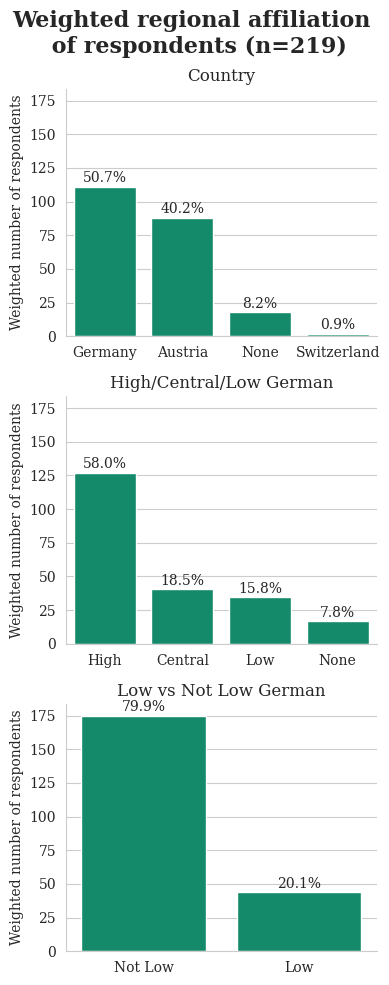

In [21]:
#======plot regional affilation distributions=====

df_weighted = df_proc.copy()

#weighted distribution of people with multiple affiliations
df_weighted['regional_group_list'] = df_weighted['regional_group'].fillna('None').str.split(', ') #fill NAs and split regional group into lists
df_weighted = df_weighted.explode('regional_group_list') #explode into one row per region per person
df_weighted['region_count'] = df_weighted.groupby('respondent')['regional_group_list'].transform('count')
df_weighted['weight'] = 1 / df_weighted['region_count'] #assign weights: each person contributes 1/n per region

#names for plot
cols = [
    ("country", "Country"),
    ("regional_group_list", "High/Central/Low German"),
    ("low_vs_notlow", "Low vs Not Low German"),
   # ("former_GDR", "Former GDR")
]

#plot
fig, axes = plt.subplots(3, 1, figsize=(4, 10), sharey=True)
fig.suptitle("Weighted regional affiliation \n of respondents (n=219)", fontsize=16, fontweight="bold")

plt.subplots_adjust(hspace=0.5)

for ax, (col, title) in zip(axes, cols):
    data = df_weighted.groupby(col)['weight'].sum().reset_index() #total up
    data = data.sort_values('weight', ascending=False) #sort highest to lowest

    sns.barplot(data=data, x=col, y='weight', ax=ax, palette=['#009E73'], hue=col, legend=False) #one colour to avoid confusing colours across plots

    #annotate bars
    for p in ax.patches:
        height = p.get_height()
        percentage = f"{100 * height / len(df_proc):.1f}%"
        ax.annotate(percentage, (p.get_x() + p.get_width() / 2, height + 1), ha='center', va='bottom', fontsize=10)

    ax.set_title(title)
    ax.set_xlabel("")
    ax.set_ylabel("Weighted number of respondents")

sns.despine()
plt.tight_layout()
plt.show()

In [22]:
df_proc_copy = df_proc.copy()

#counts in geojson dialect categories
sg_flat = (df_proc_copy["sprachgis_dialect"].dropna().str.split(",").explode().str.strip()) #flatten
sg_flat = sg_flat.str.translate(str.maketrans("", "", string.punctuation)) #remove punctuation
counts = Counter(sg_flat)
df_sg = pd.DataFrame(counts.items(), columns=["sprachgis_dialect", "count"])
df_sg = df_sg.sort_values("count", ascending=False).reset_index(drop=True)
df_sg.to_csv("./for_plotting/dialect_counts_counterlogic.csv", index=False)

df_sg


,sprachgis_dialect,count
0,Steirisch,45
1,BairischAT,36
2,BairischDE,34
3,Südbairisch,27
4,Schwäbisch,21
5,Berlinerisch,18
6,None,17
7,Ripuarisch,17
8,Fränkisch,16
9,Alemannisch,16


/var/folders/hn/q9w6s4r106lfb4wbldhkqtwr0000gp/T/ipykernel_62781/4284437687.py:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")


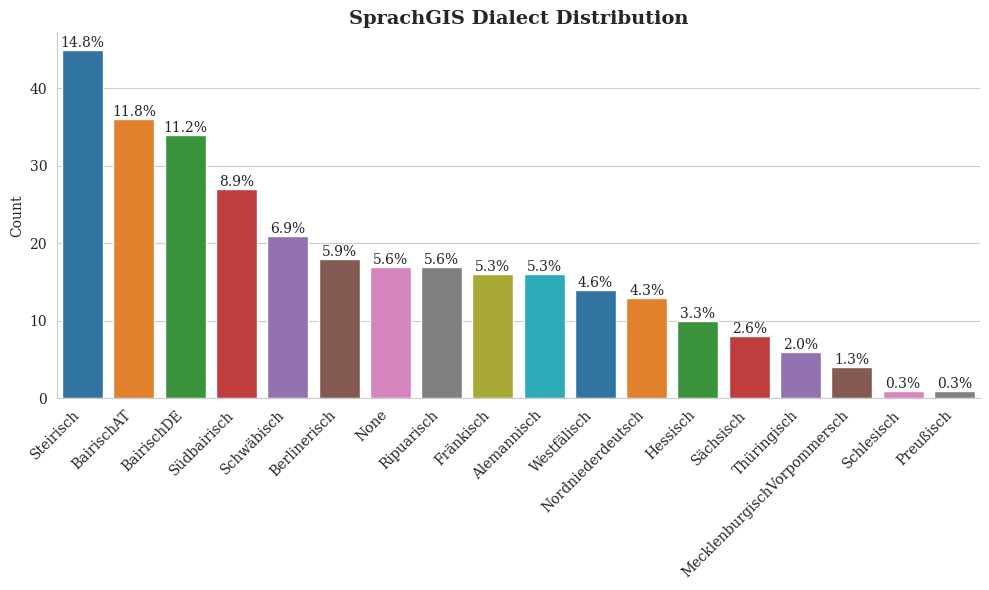

In [23]:
fig, ax = plt.subplots(figsize=(10, 6))

# Plot precomputed counts
sns.barplot(
    data=df_sg,
    x="sprachgis_dialect",
    y="count",
    palette="tab10",
    hue="sprachgis_dialect",
    legend=False,
    ax=ax
)

#percentages
total = df_sg["count"].sum()
for p in ax.patches:
    height = p.get_height()
    percentage = f"{100 * height / total:.1f}%"
    ax.annotate(percentage, (p.get_x() + p.get_width() / 2, height), ha="center", va="bottom", fontsize=10)

# Title and labels
ax.set_title("SprachGIS Dialect Distribution", fontsize=14, fontweight="bold")
ax.set_xlabel("")
ax.set_ylabel("Count")
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")

sns.despine()
plt.tight_layout()
plt.show()
#can you compare this to general population distribution? not representative of german speaking populartion but my research analysis should account for this?

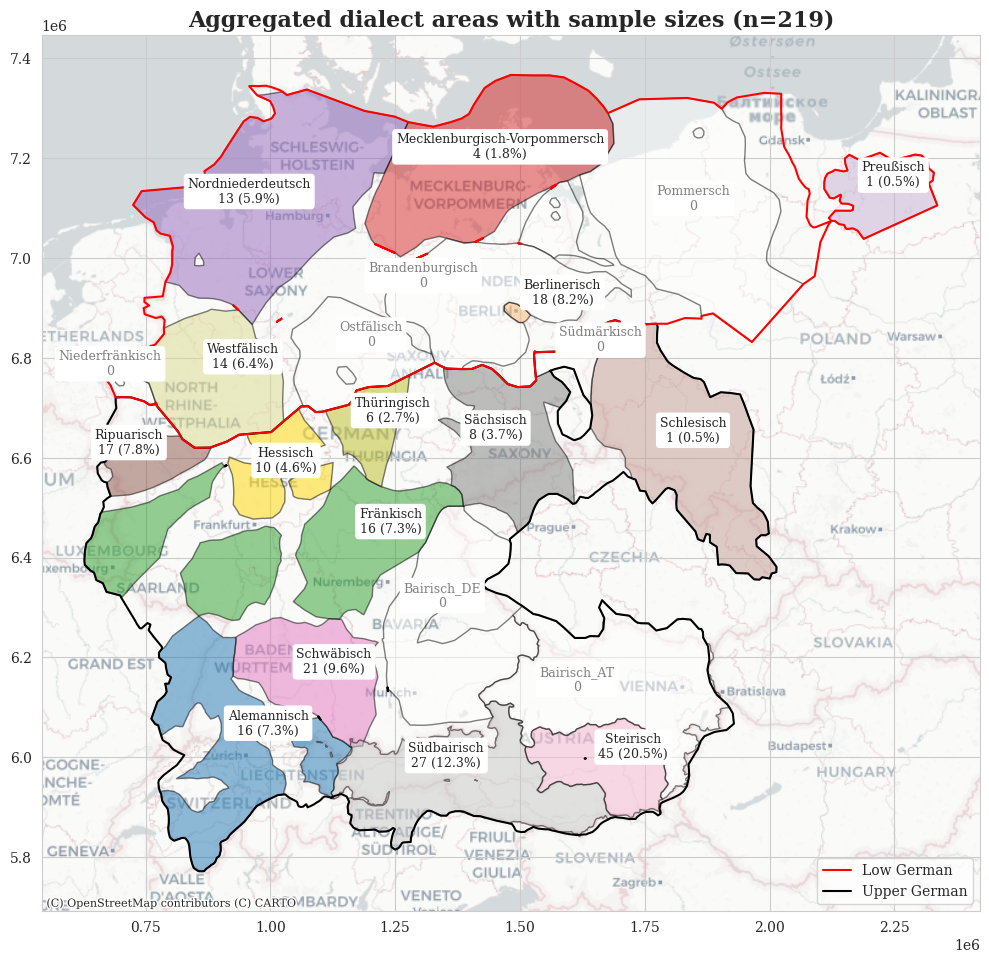

In [24]:
#plot dist on map

gdf_gjson_mercator = gpd.read_file("./geojson/agg_dialects_gdf_mercator.geojson")
low_gjson_mercator = gpd.read_file("./geojson/low_gdf_mercator.geojson")
notlow_gjson_mercator = gpd.read_file("./geojson/not_low_gdf_mercator.geojson")

# Rename mv dialect label in df_sg to match the gdf
df_sg["sprachgis_dialect"] = df_sg["sprachgis_dialect"].replace({
    "MecklenburgischVorpommersch": "Mecklenburgisch-Vorpommersch"
})

#colour mapping
dialects = sorted(df_sg["sprachgis_dialect"].unique())
palette = sns.color_palette("tab20")
color_dict = dict(zip(dialects, palette))
color_dict["Hessisch"] = "gold" #was also assigned green 
gdf_gjson_mercator["colour"] = gdf_gjson_mercator["group"].map(color_dict) #assign color to gdf
gdf_gjson_mercator["colour"] = gdf_gjson_mercator["colour"].fillna("white") #fill no sample areas with white

#merge with sample size
count_map = dict(zip(df_sg["sprachgis_dialect"], df_sg["count"]))

texts = [] #for adjust_text labelling

#plot
fig, ax = plt.subplots(figsize=(10, 10))
gdf_gjson_mercator.plot(ax=ax, color=gdf_gjson_mercator["colour"], edgecolor="black", alpha=0.5)
cx.add_basemap(ax, source=cx.providers.CartoDB.Positron)
ax.set_title("Aggregated dialect areas with sample sizes (n=219)", fontsize=16, fontweight="bold")

#add labels
for idx, row in gdf_gjson_mercator.iterrows():
    label = row["group"]
    count = count_map.get(label, 0)
    point = row.geometry.representative_point()

    #move poorly placed labels
    if label == "Alemannisch":
        point = point.coords[0]
        x, y = point[0] - 50000, point[1] 
    elif label == "Bairisch_AT":
        point = point.coords[0]
        x, y = point[0] - 60000, point[1] 
    else:
        x, y = point.x, point.y

    #label text - count vs no count
    if count == 0:
        text_str = f"{label}\n{count}"
        txt = ax.text(x, y, text_str, fontsize=9, ha="center", color="grey",
                      bbox=dict(facecolor="white", edgecolor="none", boxstyle="round,pad=0.3"))
    else:
        text_str = f"{label}\n{count} ({count/219*100:.1f}%)"
        txt = ax.text(x, y, text_str, fontsize=9, ha="center",
                      bbox=dict(facecolor="white", edgecolor="none", boxstyle="round,pad=0.3"))

    texts.append(txt)
adjust_text(texts, ax=ax)

#plot outlines
notlow_gjson_mercator.plot(ax=ax, edgecolor='black', facecolor='none', linewidth=1.5, zorder=1)
low_gjson_mercator.plot(ax=ax, edgecolor='red', facecolor='none', linewidth=1.5, zorder=1)

#legend
handles = [
    Line2D([0], [0], color='red', lw=1.5, label='Low German'),
    Line2D([0], [0], color='black', lw=1.5, label='Upper German'),
]
ax.legend(handles=handles, loc='lower right')

plt.tight_layout()
plt.show()

In [25]:
#save processed data
path = "./data/Data_processed.csv"
save_csv(df_proc, path)

# Count up plural endings

In [26]:
endings_map = {
    "0": ["e"],
    "s": ["s", "es"],
    "n": ["n", "en"],
    "r": ["r", "er"],
}

def get_plural_ending_label(col_name, plural):
    if pd.isna(plural) or plural.strip() == "":
        return "None"

    singular = col_name.strip().split()[1].strip().lower()
    plural = plural.strip().lower()

    # zero ending: exact match or +e
    if plural == singular or plural == singular + "e":
        return "0"

    for label, suffixes in endings_map.items():
        if label == "0": 
            continue
        if plural == "mafferer": #manual override as it was the only instances classified as Other 
            return "r"
        for suf in suffixes:
            if plural.endswith(suf) and not singular.endswith(suf):
                return label

    return "Other"

def count_endings(df, tok_cols):
    ending_counters = {}
    for col in tok_cols:
        endings = df[col].apply(lambda plural: get_plural_ending_label(col, plural))
        ending_counters[col] = Counter(endings)
    df_endings_summary = pd.DataFrame(ending_counters).T.fillna(0).astype(int)
    df_endings_summary.reset_index(inplace=True)
    df_endings_summary["row_total"] = df_endings_summary[df_endings_summary.columns[1:-1]].sum(axis=1)
    return df_endings_summary

df_proc = pd.read_csv("./data/Data_processed.csv")
dfproc_endings = count_endings(df_proc, tokens_cols)
dfproc_endings

,index,s,None,0,n,r,row_total
0,der Park,212,2,5,0,0,219
1,der Biskuit,191,0,26,2,0,219
2,der Jodel,32,4,152,23,8,211
3,der Schal,202,0,17,0,0,219
4,der Test,211,0,8,0,0,219
5,der Boykott,106,1,112,0,0,219
6,das Kabarett,169,0,50,0,0,219
7,das Bukett,177,0,28,13,1,218
8,das Labor,37,6,174,2,0,219
9,das Fazit,118,9,91,1,0,219


In [27]:
#percentages - need to use % instead of counts bc not all answers were valid
def get_percentages(df, rounding=2):
    for ending in ["0", "n", "s", "r"]:
        df[f"{ending}_pct"] = (df[ending] / (df["row_total"]-df["None"]) * 100)
    pct_cols = [f"{ending}_pct" for ending in ["0", "n", "s", "r"]]
    df_percentages = df[["index"] + pct_cols].round(rounding)
    df_percentages["row_total"] = df_percentages[df_percentages.columns[1:]].sum(axis=1)
    return df_percentages

dfproc_percent = get_percentages(dfproc_endings)
dfproc_percent

,index,0_pct,n_pct,s_pct,r_pct,row_total
0,der Park,2.30,0.00,97.70,0.00,100.00
1,der Biskuit,11.87,0.91,87.21,0.00,99.99
2,der Jodel,73.43,11.11,15.46,3.86,103.86
3,der Schal,7.76,0.00,92.24,0.00,100.00
4,der Test,3.65,0.00,96.35,0.00,100.00
5,der Boykott,51.38,0.00,48.62,0.00,100.00
6,das Kabarett,22.83,0.00,77.17,0.00,100.00
7,das Bukett,12.84,5.96,81.19,0.46,100.45
8,das Labor,81.69,0.94,17.37,0.00,100.00
9,das Fazit,43.33,0.48,56.19,0.00,100.00


In [28]:
#remove fillers
fillers = df_proc.columns[22:31]
df_nofills = df_proc.drop(fillers, axis=1)
df_nofills.reset_index(inplace=True, drop=True)
no_fill_toks = df_nofills.columns[7:-7]
dfnofills_count = count_endings(df_nofills, no_fill_toks)
dfnofills_pct = get_percentages(dfnofills_count)
dfnofills_endings = pd.merge(dfnofills_count, dfnofills_pct, left_index=True,right_index=True)
dfnofills_endings


,index_x,s,None,0,n,r,row_total_x,0_pct_x,n_pct_x,s_pct_x,r_pct_x,index_y,0_pct_y,n_pct_y,s_pct_y,r_pct_y,row_total_y
0,der Park,212,2,5,0,0,219,2.304147,0.000000,97.695853,0.000000,der Park,2.30,0.00,97.70,0.00,100.00
1,der Biskuit,191,0,26,2,0,219,11.872146,0.913242,87.214612,0.000000,der Biskuit,11.87,0.91,87.21,0.00,99.99
2,der Jodel,32,4,152,23,8,211,73.429952,11.111111,15.458937,3.864734,der Jodel,73.43,11.11,15.46,3.86,103.86
3,der Schal,202,0,17,0,0,219,7.762557,0.000000,92.237443,0.000000,der Schal,7.76,0.00,92.24,0.00,100.00
4,der Test,211,0,8,0,0,219,3.652968,0.000000,96.347032,0.000000,der Test,3.65,0.00,96.35,0.00,100.00
5,der Boykott,106,1,112,0,0,219,51.376147,0.000000,48.623853,0.000000,der Boykott,51.38,0.00,48.62,0.00,100.00
6,das Kabarett,169,0,50,0,0,219,22.831050,0.000000,77.168950,0.000000,das Kabarett,22.83,0.00,77.17,0.00,100.00
7,das Bukett,177,0,28,13,1,218,12.844037,5.963303,81.192661,0.458716,das Bukett,12.84,5.96,81.19,0.46,100.45
8,das Labor,37,6,174,2,0,219,81.690141,0.938967,17.370892,0.000000,das Labor,81.69,0.94,17.37,0.00,100.00
9,das Fazit,118,9,91,1,0,219,43.333333,0.476190,56.190476,0.000000,das Fazit,43.33,0.48,56.19,0.00,100.00


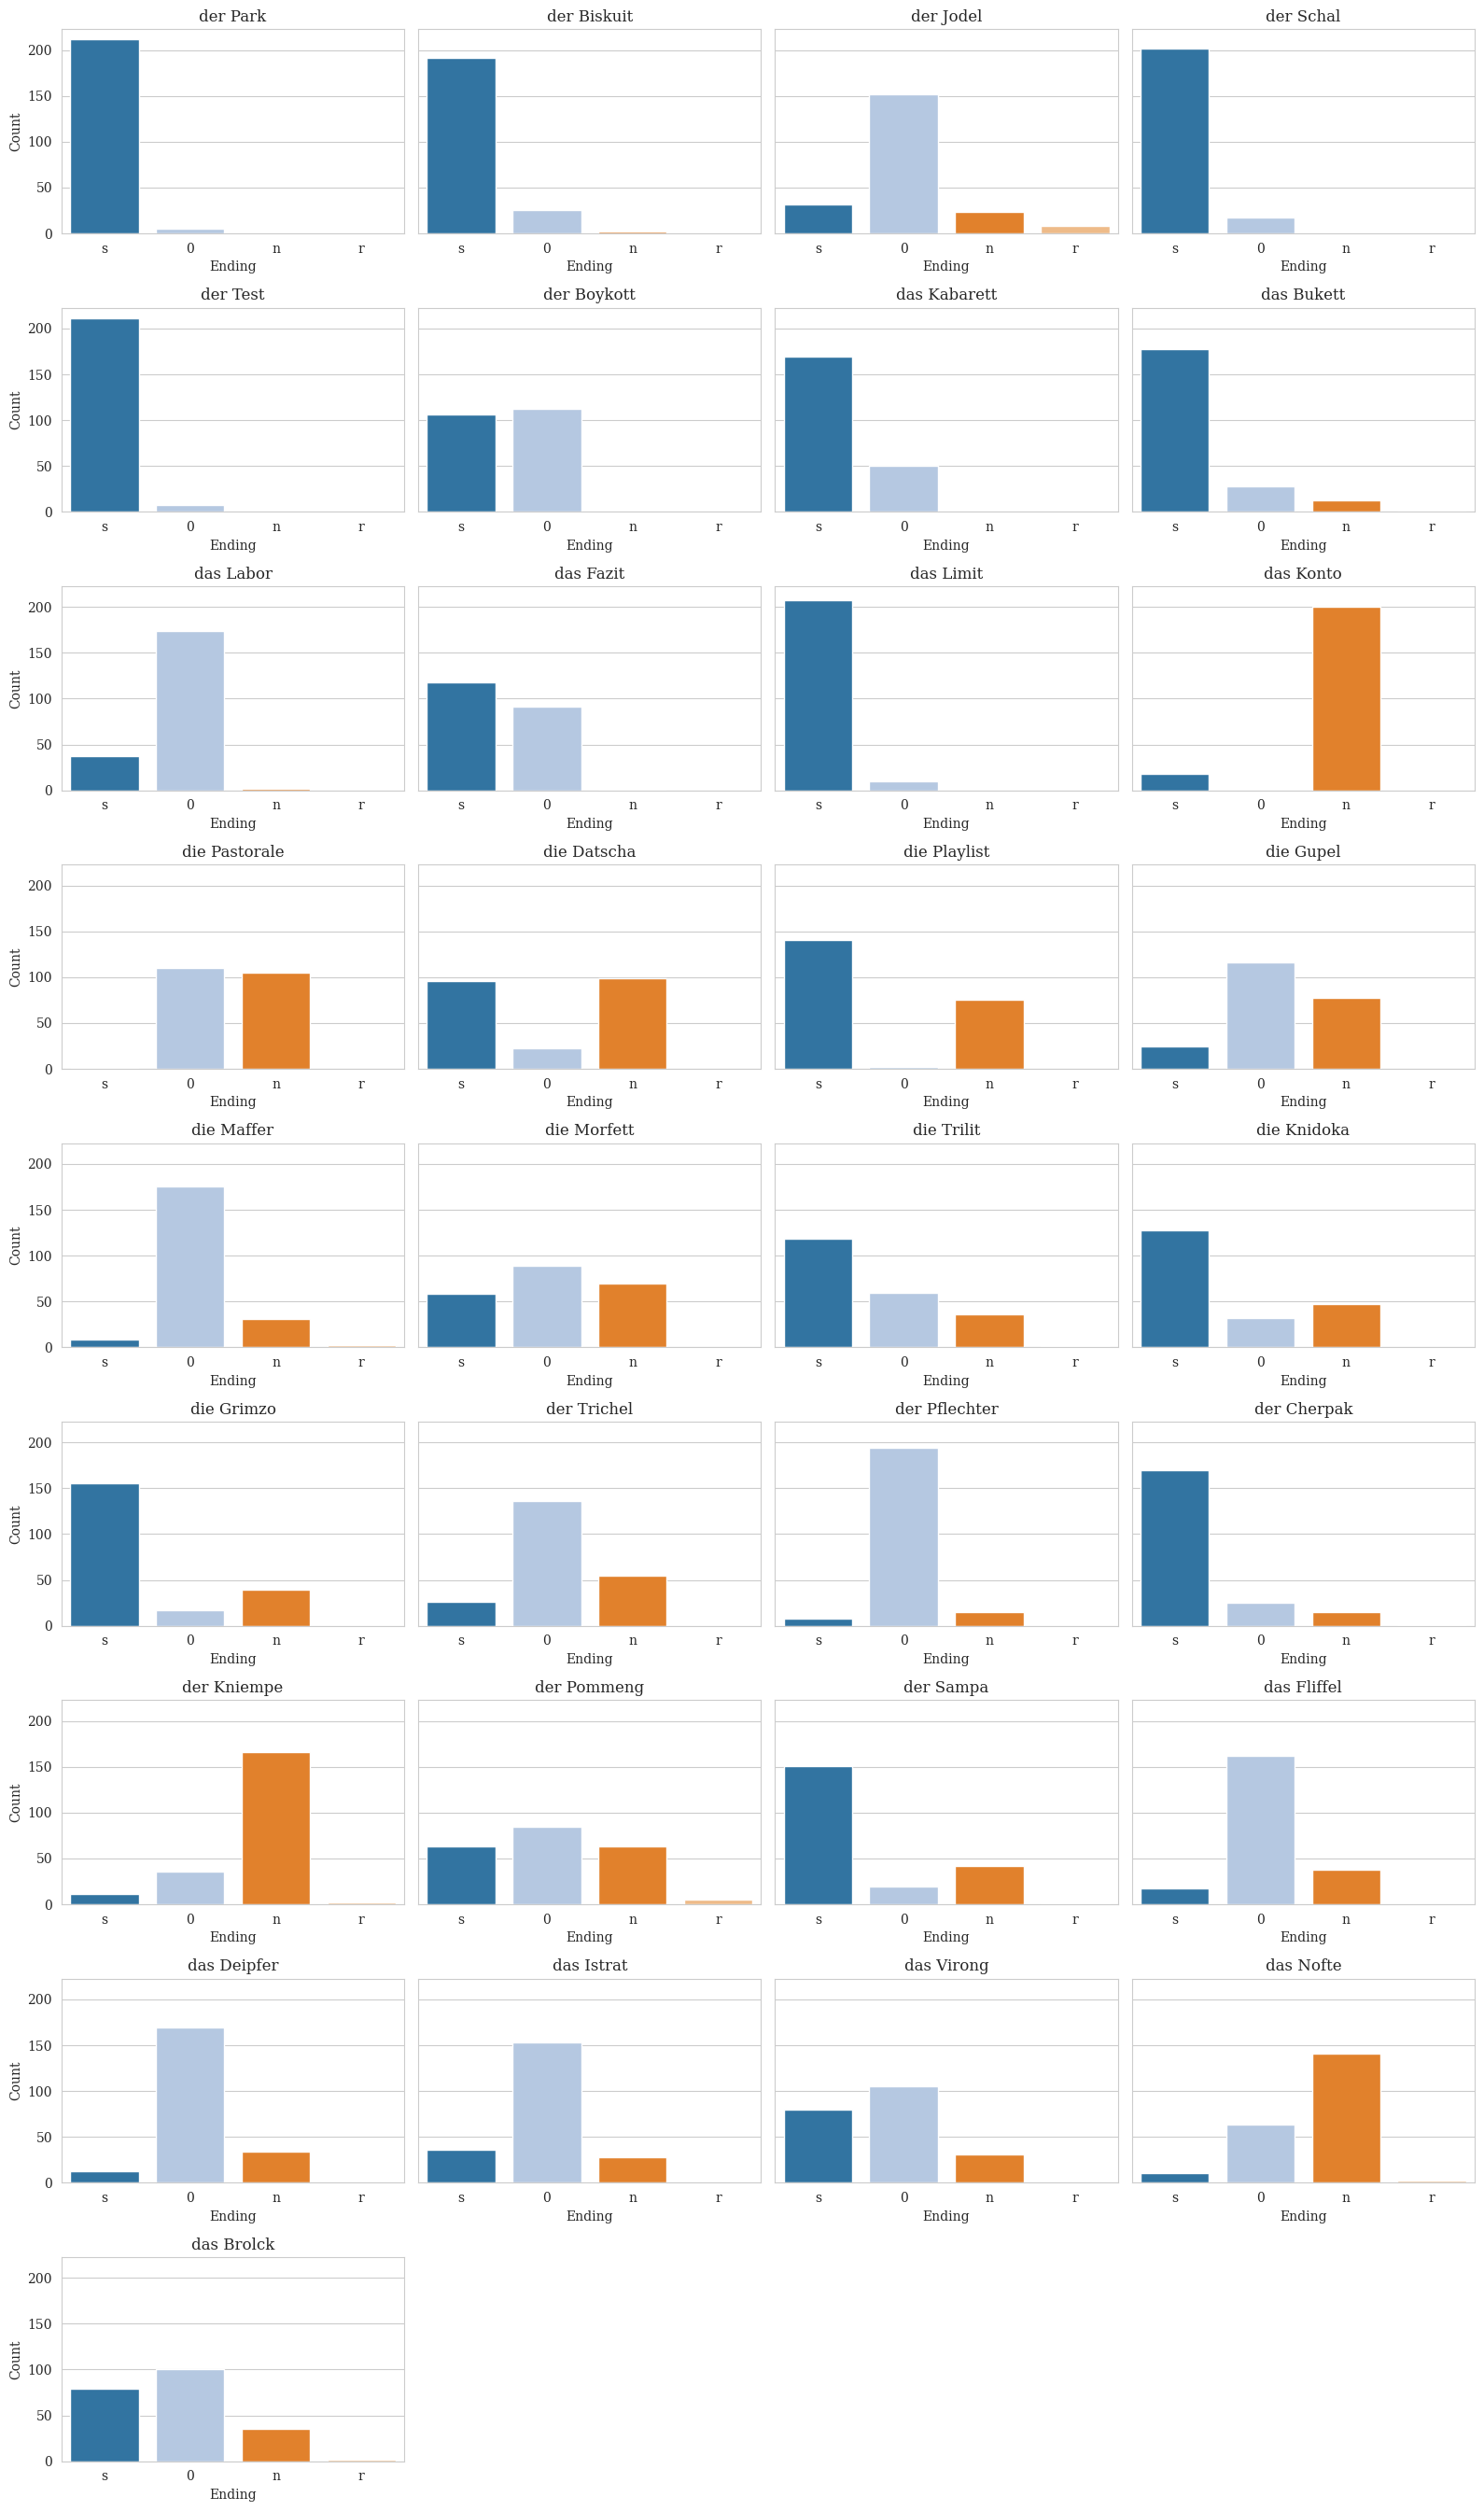

In [29]:
#plot tokens endings
df = dfnofills_endings.copy()
cols = ["s", "0", "n", "r"]

#subplots grid
n_rows = len(df)
n_cols = 4  
n_subplots = len(df)
n_cols = 4
n_rows = (n_subplots // n_cols) + int(n_subplots % n_cols > 0)

#plot
fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 4, n_rows * 3), sharey=True)
axes = axes.flatten()
for i, (idx, row) in enumerate(df.iterrows()):
    ax = axes[i]
    counts = row[cols]

    sns.barplot(x=counts.index, y=counts.values, ax=ax, hue=cols)
    ax.set_title(row["index_x"])
    ax.set_xlabel("Ending")
    ax.set_ylabel("Count")

for j in range(i+1, len(axes)):
    fig.delaxes(axes[j]) #remove any unused axes

plt.tight_layout()
plt.show()

In [30]:
#save alternations and neologisms separately
df_alternations = dfnofills_endings[0:15]
df_nonsense = dfnofills_endings[15:]

save_csv(df_alternations, "./data/percentages/alternations_endings.csv")
save_csv(df_nonsense, "./data/percentages/neologisms_endings.csv")

In [31]:
def count_s_and_total(row):
    s_count = 0
    total_count = 0

    for tok in no_fill_toks:
        plural = row[tok]
        if pd.notna(plural):  #skip missing values
            ending = get_plural_ending_label(tok, plural)
            if ending == "s":
                s_count += 1
            total_count += 1

    percent_s = (s_count / total_count) * 100 if total_count > 0 else np.nan

    return pd.Series({"total_s": s_count, "percent_s": round(percent_s, 2)})

#define tokens and count s-plurals
df_nofills[["total_s","percent_s"]] = df_nofills.apply(count_s_and_total, axis=1)
df_nofills.head()

,respondent,bilingual,age,gender,dialects,years_abroad,time_abroad_place,der Park,der Biskuit,der Jodel,...,das Brolck,total_tokens,dialect_count,sprachgis_dialect,regional_group,low_vs_notlow,country,former_GDR,total_s,percent_s
0,1,0,19-30,0.0,"bairisch, schwäbisch",10+,NaN,parks,biskuits,jodel,...,brolcke,42,2,"Bairisch_DE, Schwäbisch",High,Not Low,Germany,False,13.0,39.39
1,2,1,19-30,0.0,keine,1-5,NaN,parks,biskuits,jodel,...,brolcks,42,0,NaN,NaN,Not Low,NaN,False,16.0,48.48
2,3,1,19-30,0.0,kärntnerisch,<1,NaN,parks,biskuits,jodel,...,brolcke,42,1,Südbairisch,High,Not Low,Austria,False,15.0,46.88
3,4,0,19-30,1.0,thüringisch,<1,NaN,parks,biskuits,jodel,...,brolcken,42,1,Thüringisch,Central,Not Low,Germany,True,9.0,28.12
4,5,0,19-30,1.0,bairisch,<1,NaN,parks,biskuit,jodel,...,brolcke,42,1,Bairisch_DE,High,Not Low,Germany,False,11.0,34.38


In [32]:
save_csv(df_nofills, "./data/data_for_plotting.csv")

# Exploring make up of groups

In [33]:
df_proc = pd.read_csv("./data/data_for_plotting.csv")
df_proc.head()

,respondent,bilingual,age,gender,dialects,years_abroad,time_abroad_place,der Park,der Biskuit,der Jodel,...,das Brolck,total_tokens,dialect_count,sprachgis_dialect,regional_group,low_vs_notlow,country,former_GDR,total_s,percent_s
0,1,0,19-30,0.0,"bairisch, schwäbisch",10+,NaN,parks,biskuits,jodel,...,brolcke,42,2,"Bairisch_DE, Schwäbisch",High,Not Low,Germany,False,13.0,39.39
1,2,1,19-30,0.0,keine,1-5,NaN,parks,biskuits,jodel,...,brolcks,42,0,NaN,NaN,Not Low,NaN,False,16.0,48.48
2,3,1,19-30,0.0,kärntnerisch,<1,NaN,parks,biskuits,jodel,...,brolcke,42,1,Südbairisch,High,Not Low,Austria,False,15.0,46.88
3,4,0,19-30,1.0,thüringisch,<1,NaN,parks,biskuits,jodel,...,brolcken,42,1,Thüringisch,Central,Not Low,Germany,True,9.0,28.12
4,5,0,19-30,1.0,bairisch,<1,NaN,parks,biskuit,jodel,...,brolcke,42,1,Bairisch_DE,High,Not Low,Germany,False,11.0,34.38


In [34]:
#==OVER 60==
mask = df_proc["age"] == "60+"
df_proc[mask]

,respondent,bilingual,age,gender,dialects,years_abroad,time_abroad_place,der Park,der Biskuit,der Jodel,...,das Brolck,total_tokens,dialect_count,sprachgis_dialect,regional_group,low_vs_notlow,country,former_GDR,total_s,percent_s
81,82,0,60+,0.0,bairisch,10+,NaN,parks,biskuits,jodel,...,brolcks,42,1,Bairisch_DE,High,Not Low,Germany,False,19.0,57.58
155,156,0,60+,1.0,saarländisch,<1,NaN,parks,biskuits,jodel,...,brolcks,42,1,Fränkisch,Central,Not Low,Germany,False,16.0,48.48
185,186,0,60+,0.0,"bairisch, berlinerisch, hessisch, schwäbisch",10+,NaN,parks,biskuits,jodel,...,brolcke,42,4,"Bairisch_DE, Berlinerisch, Hessisch, Schwäbisch","High, Central, Low",Low,Germany,True,19.0,57.58
191,192,0,60+,1.0,"berlinerisch, sächsisch, schwäbisch",10+,NaN,parks,biskuits,jodels,...,brolcks,42,3,"Berlinerisch, Schwäbisch, Sächsisch","High, Central, Low",Low,Germany,True,18.0,54.55
193,194,0,60+,0.0,keine,10+,NaN,parks,biskuits,jodeln,...,brolcks,42,0,NaN,NaN,Not Low,NaN,False,12.0,36.36
201,202,1,60+,1.0,schlesisch,10+,england/singapur/frankreich,parks,biskuits,jodel,...,brolcks,42,1,Schlesisch,Central,Not Low,Germany,False,16.0,51.61
209,210,0,60+,0.0,lippisch,<1,NaN,parks,biskuits,jodel,...,NaN,42,1,Westfälisch,Low,Low,Germany,False,9.0,64.29
210,211,0,60+,0.0,bairisch,<1,NaN,parks,biskuits,jodel,...,brolcken,42,1,Bairisch_DE,High,Not Low,Germany,False,14.0,42.42
211,212,0,60+,0.0,keine,<1,NaN,parks,biskuits,jodeln,...,brolcks,42,0,NaN,NaN,Not Low,NaN,False,18.0,54.55
217,218,0,60+,0.0,keine,1-5,"england, frankreich",parks,biskuits,jodel,...,brolck,42,0,NaN,NaN,Not Low,NaN,False,20.0,60.61


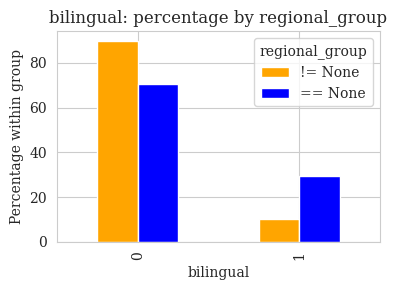

Chi2 statistic = 3.754
p-value = 0.0527
Degrees of freedom = 1


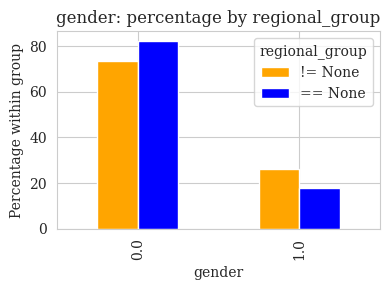

Chi2 statistic = 0.251
p-value = 0.6162
Degrees of freedom = 1


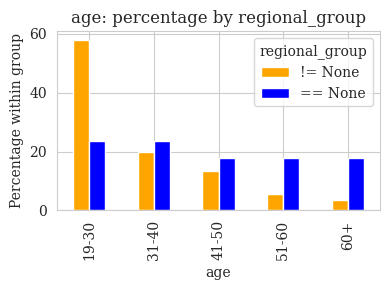

Chi2 statistic = 14.233
p-value = 0.0066
Degrees of freedom = 4


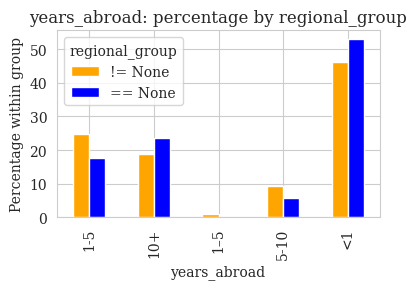

Chi2 statistic = 1.051
p-value = 0.9020
Degrees of freedom = 4


In [35]:
#===NO AFFILIATION==
from scipy.stats import chi2_contingency

mask_none = df_proc["regional_group"].isna()
categorical_cols = ['bilingual', 'gender', 'age','years_abroad']

for col in categorical_cols:
    ctab = pd.crosstab(df_proc[col], mask_none) #contingency table
    ctab_percent = ctab.div(ctab.sum(axis=0), axis=1) * 100 #convert to %
    ctab_percent.columns = ['!= None', '== None'] #rename columns for legend

    #plot
    ctab_percent.plot(kind='bar', figsize=(4, 3), color=['orange', 'blue'])
    plt.title(f'{col}: percentage by regional_group')
    plt.ylabel('Percentage within group')
    plt.xlabel(col)
    plt.legend(title='regional_group')
    plt.tight_layout()
    plt.show()

    #is any difference significant?
    chi2, p, dof, expected = chi2_contingency(ctab)
    print(f"Chi2 statistic = {chi2:.3f}")
    print(f"p-value = {p:.4f}")
    print(f"Degrees of freedom = {dof}")

In [ ]:
# #=====East vs West DE=====
# #load geojson files
# west_de = gpd.read_file("./geojson/westdl.geojson")
# east_de = gpd.read_file("./geojson/ostdl.geojson")

# east_poly = east_de.to_crs(epsg=3857).unary_union
# west_poly= west_de.to_crs(epsg=3857).unary_union

# df_ew = df_proc.copy()

# #define tokens and count s-plurals
# tokens = df_ew.columns[7:-7]
# df_ew[["total_s", "percent_s"]] = df_ew.apply(count_s_and_total, axis=1)

# #calc mean over aggregated groups and then assign geometry (making sure crs matches that of polygons)
# agg = df_ew.groupby("former_GDR", dropna=True)["percent_s"].mean().reset_index()
# agg["geometry"] = agg["former_GDR"].map({True: east_poly, False: west_poly})
# gdf_agg = gpd.GeoDataFrame(agg, geometry="geometry", crs="EPSG:3857")

# #plot
# fig, ax = plt.subplots(1, 1, figsize=(10,10))
# gdf_agg.plot(
#     column="percent_s",
#     cmap="viridis",
#     legend=False,
#     edgecolor="white",
#     linewidth=0.8,
#     alpha=0.5,
#     ax=ax
# )
# cx.add_basemap(ax, source=cx.providers.CartoDB.Positron)

# #add labels
# for idx, row in gdf_agg.iterrows():
#     geom = row["geometry"]
#     if geom is None or geom.is_empty:
#         continue
#     centroid = row["geometry"].centroid
#     ax.text(
#         centroid.x,
#         centroid.y,
#         f"{row['percent_s']:.1f}%",
#         ha="center",
#         va="center",
#         fontsize=12,
#         color="black",
#         weight="bold",
#         bbox=dict(facecolor='white', alpha=1, edgecolor='none', boxstyle='round,pad=0.2')
#     )

# #ax.set_axis_off() - show lat/long
# #ax.set_aspect('auto')
# ax.set_title("Mean % of -s Plurals by Region", fontsize=14)
# plt.show()


In [ ]:
# #=====AT vs DE=====
# #get single geometry location
# at_geom = at_country.geometry.iloc[0]
# de_geom = de_country.geometry.iloc[0]
# ch_geom = ch_country.geometry.iloc[0]

# #copy respondents and assign geometry
# df_deat = df_proc.copy()
# df_deat.loc[df_deat["country"] == "Germany", "geometry"] = de_geom
# df_deat.loc[df_deat["country"] == "Austria", "geometry"] = at_geom
# df_deat.loc[df_deat["country"] == "Switzerland", "geometry"] = ch_geom
# df_deat.loc[~df_deat["country"].isin(["Germany", "Austria", "Switzerland"]), "geometry"] = np.nan

# #define tokens and count s-plurals
# tokens = df_deat.columns[7:-7]
# df_deat[["total_s", "percent_s"]] = df_deat.apply(count_s_and_total, axis=1)

# #save data
# df_deat.to_csv("./data_with_DEAT_geometry.csv", index=False, encoding="utf-8")

# #drop unneeded columns
# cols_to_drop = [df_deat.columns[:-3], "total_s"]
# for col in cols_to_drop:
#     df_deat = df_deat.drop(columns=col)

# #save data for plotting
# gdf_deat = gpd.GeoDataFrame(df_deat, geometry="geometry", crs="EPSG:4326").dropna()
# gdf_deat.to_file("./DEAT_data_for_plotting.geojson", driver="GeoJSON")
# gdf_deat.head()

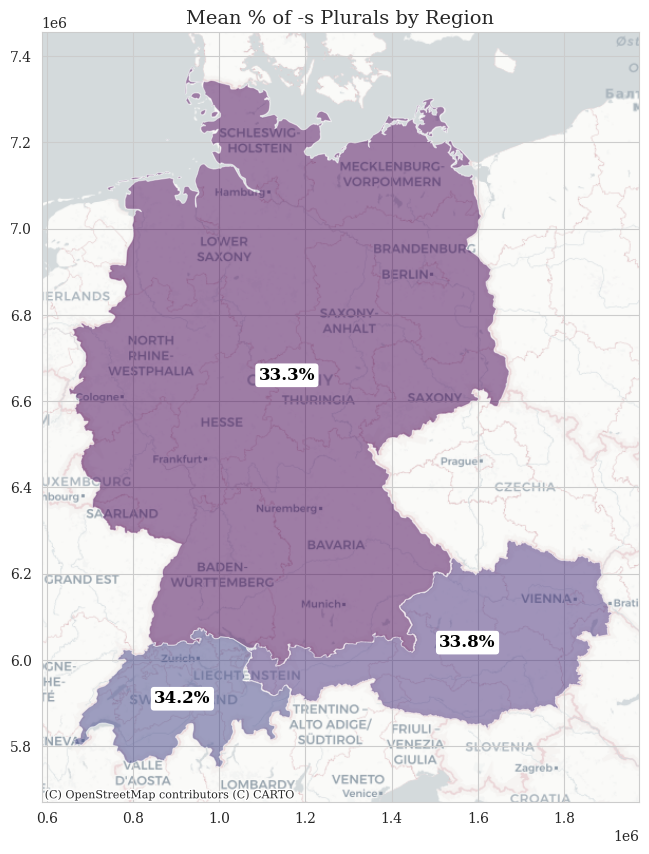